# Camera calibration and bumblebee body orientation reconstruction

### Read 2D and 3D corresponding points

In [12]:
#focal length in mm 
f2 = 35 + 15 *8/9
f1 = 35 + 15 *6/9

In [13]:
import cv2

In [14]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [15]:
Cam1_2d = pd.read_csv('Cam1_2Dpts.csv')
Cam1_2d.head()

,cam1_X,cam1_Y
0,323.687649,696.859015
1,262.855573,731.162051
2,264.005240,719.701261
3,177.908713,772.367009
4,504.858537,701.692581


In [16]:
Cam1_3d = pd.read_csv('Cam1_3DPts.csv')
Cam1_3d.head()

,x,y,z
0,0.0,3.3,3.30
1,0.0,3.3,91.65
2,3.3,3.3,91.65
3,0.0,0.0,180.00
4,0.0,62.2,3.30


In [17]:
Cam2_2d = pd.read_csv('Cam2_2Dpts.csv')
Cam2_2d.head()

,cam1_X,cam1_Y
0,123.821919,730.885756
1,201.968552,782.816845
2,201.605764,768.986946
3,251.110516,699.724147
4,349.264889,725.119113


In [18]:
Cam2_3d = pd.read_csv('Cam2_3DPts.csv')
Cam2_3d.shape

(41, 3)

In [19]:
# GET RID OF NAN
Cam1_notnull = Cam1_2d.dropna()
Cam2_notnull = Cam2_2d.dropna()
Cam1_2d_np = np.array(Cam1_notnull).T
Cam2_2d_np = np.array(Cam2_notnull).T
Cam1_3d_np = np.array(Cam1_3d.iloc[Cam1_notnull.index]).T
Cam2_3d_np = np.array(Cam2_3d.iloc[Cam2_notnull.index]).T

In [20]:
# imgae Y axis go downwards

Cam1_2d_np[1,:] = 800 - Cam1_2d_np[1,:]
Cam2_2d_np[1,:] = 800 - Cam2_2d_np[1,:]

In [21]:
Cam1_3d_np.shape

(3, 34)

### Outlier rejection
The MSAC algorithm is applied to reject the outliers. For each trial, randomly select three points from the 2D normalized points and world 3D points respectively. 3-point algorithm of Finsterwalder is used to ﬁnd those three corresponding points in the camera frame. And Umeyama algorithm is applied to estimate camera pose rotation R and translation t from the coordinates of camera frame to world frame. Apply this transformation to all 3D points and compute projection error. Label each points either inliers or outliers based on the squared distance tolerance. $t^{2} = f^{-1}_{m}(\alpha)\sigma^{2} $. The tolerance is calculated via chi-sqaured cumulative distribution function with m = 2 degree of freedom at the probability α =0.95 and variance σ2 assumed to be 1. This algorithm will stop when the number of iteration reach to the max iteration. $max\_trial = \frac{log(1-p)}{log(1-w^{s})}$ ,where p is the probability that at least one of the random samples does not contain any outliers and is chosen to be 0.99. s is the sample size and w is the probability that a data point is an inlier

In [22]:
import numpy as np
import time

def Homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))

def Dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1]/x[-1]

    
def intrinsic_K(f,pixel_pitch,px,py):
    #Estimate intrinsic matrix K
    #square pixel and no shear distortion
    #inputs: 
    #    f - focal length 
    #    pixel_pitch - pixel size 
    #    px,py - principal pts 
    #output:
    #    K - intrinsic matrix  
    K = np.eye(3) * f/pixel_pitch
    K[-1,-1] = 1
    K[0,-1] = px
    K[1,-1] = py
    return K
    
#f = 35 + 15*3/4   # unit -- mm
pixel_pitch = 20/1e3 #   mm/pixel
px = 639
py = 399

K1 = intrinsic_K(f1,pixel_pitch , px, py)
K2 = intrinsic_K(f2,pixel_pitch , px, py)

print('K1 =')
print(K1)

print('K2 =')
print(K2)

    
def ComputeCost(P, x, X):
    # Inputs:
    #    P - camera projection matrix
    #    x - 2D groundtruth image points
    #    X - 3D groundtruth scene points
    #    K - camera calibration matrix
    #
    # Output:
    #    cost - total projection error --- >  2d pts inhomo
    #n = x.shape[1]
    
    #covarx = np.eye(2*n) # covariance propagation
    
    """your code here"""
    x_est = Dehomogenize(P @ Homogenize(X))
    
    
    cost = ((x - x_est)**2).sum()
    return cost



K1 =
[[2.25e+03 0.00e+00 6.39e+02]
 [0.00e+00 2.25e+03 3.99e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
K2 =
[[2.41666667e+03 0.00000000e+00 6.39000000e+02]
 [0.00000000e+00 2.41666667e+03 3.99000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [23]:
def Back_Proj(x,K):
    # Inputs:
    #    x - 2D inhomogeneous image points (2*n)
    #    K - camera calibration matrix
    # Output:
    #    d - 3D unit ray in Camera frame (inhomo)(3*n)
    d = np.linalg.inv(K) @ Homogenize(x)  #(3*n)
    d_normalized = d/(np.sign(d[2])*np.linalg.norm(d,axis = 0))
    return d_normalized

In [24]:
def P_extrinsic(R,T):
    P_ext = np.eye(4) 
    P_ext[:-1,:-1] = R
    P_ext[:-1,-1] =  T.reshape(-1)
    return P_ext
    

In [25]:
def P_proj(R,T, K):
    P_ext = P_extrinsic(R,T)
    Iden = np.hstack((np.eye(3),np.zeros((3,1))))
    P = K @ Iden @ P_ext
    return P

In [26]:
def Pose_estimation(p,X,K):
    # Inputs:
    #    Least_square_estimation (Umeyama paper)
    #    X - 3*n 3D PTS in world frame (inhomo)  hstack 
    #    p - 3*n 3D PTS in cam frame (inhomo)  hstack
    #    K - camera calibration matrix
    # Output:
    #    R,T - Camera pose 
    #    P - Camera projection matrix 
    #    Cost  - SUM OF SQUARE ERROR OF 2D INHOMO PTS
    #p = np.hstack((p1,p2,p3))  # P Camera frame 
    mean_p = np.mean(p,axis = 1).reshape(-1,1)  #(3,1)
    #X = np.hstack((X1,X2,X3))  # X World frame 
    mean_X = np.mean(X,axis = 1).reshape(-1,1)
    # Mean_deviation form B,C
    C = (p - mean_p).T    # Cam
    B = (X - mean_X).T   # World
    Sigma = (C.T @ B)/p.shape[1]
    u,d,vh = np.linalg.svd(Sigma)
    eye = np.eye(3)
    if (np.linalg.det(u)*np.linalg.det(vh.T)) < 0:  # Make sure det(R) = +1
        eye[-1,-1] = -1 
        R = u @ eye @ vh
    else:
        R = u @ vh  # 3*3
    T = mean_p - R @ mean_X    #3*1
    P = P_proj(R,T,K)
    #Cost = ComputeCost(P, x, X)
    
    
    return R,T ,P
    

In [27]:
#USE minimum lbda
def P3P(x,X,K):
    # Inputs:
    #    Finsterwalder's Solution 
    #    pick three pts from database randomly 
    #    x - 2D inhomogeneous image points (3 pts hstack)
    #    X - 3D inhomogeneous scene (World) points (3 pts hstack)
    #    K - camera calibration matrix
    # Output:
    #    p_3pts_Cam - 3d pts in Camera frame (inhomo)  (3*3, p1,p2,p2 hstack )   
    #    R,T - corresponding camera pose 
    #    P - Camera projection matrix 
    R = np.zeros((4,3,3))
    T = np.zeros((4,3,1))
    P = np.zeros((4,3,4))
    p_3pts = np.zeros((4,3,3))
    a = np.linalg.norm(X[:,1]-X[:,2])
    b = np.linalg.norm(X[:,2]-X[:,0])
    c = np.linalg.norm(X[:,0]-X[:,1])
    j = Back_Proj(x,K)
    cos_a = (j[:,1]*j[:,2]).sum() #alpha
    cos_b = (j[:,0]*j[:,2]).sum()  #beta
    cos_g = (j[:,0]*j[:,1]).sum()  #gamma
    sin_a2 = 1 - cos_a**2
    sin_b2 = 1 - cos_b**2
    sin_g2 = 1 - cos_g**2
    G = c**2*(c**2*sin_b2 - b**2*sin_g2)
    H = b**2*(b**2-a**2)*sin_g2 + c**2*(c**2+2*a**2)*sin_b2 + 2*b**2*c**2*(-1 + cos_a*cos_b*cos_g)
    I = b**2*(b**2-c**2)*sin_a2 + a**2*(a**2+2*c**2)*sin_b2 + 2*b**2*a**2*(-1 + cos_a*cos_b*cos_g)
    J = a**2*(a**2*sin_b2-b**2*sin_a2)
    coeff = [G,H,I,J]
    root = np.roots(coeff)
    real_values = root[np.isreal(root)]
    if real_values.size != 0:
        real_flt64 = real_values.real[abs(real_values.imag)<1e-5]   #real_flt64 
        lbda = real_flt64.max()
        #print('Lambda:    ',lbda) # 3
        


        A = 1 + lbda
        B = -cos_a 
        C = (b**2-a**2)/b**2 - lbda*c**2/b**2
        D = -lbda*cos_g
        E = (a**2/b**2 + lbda*c**2/b**2)*cos_b
        F = -a**2/b**2 + lbda*(b**2-c**2)/b**2
        if (B**2-A*C > 0) and (E**2-C*F>0):
            p = np.sqrt(B**2-A*C)
            q = np.sign(B*E-C*D)*np.sqrt(E**2-C*F)
            m = np.array([(-B + p)/C,(-B - p)/C])
            
            n = np.array([(-E + q)/C,(-E - q)/C]) #(2,)
            #v = um +n 
            A_u = b**2 - m**2 *c**2
            B_u = c**2*(cos_b-n)*m-b**2*cos_g
            C_u = -c**2*n**2 + 2*c**2*n*cos_b+b**2-c**2

            sqrt_valued = B_u**2-A_u*C_u
            mask = sqrt_valued> 0
            pos_valued = sqrt_valued[mask]
            #print('pos_valued:    ',pos_valued)
            A_u = A_u[mask]
            B_u = B_u[mask]
            C_u = C_u[mask]
            if pos_valued.size != 0:
                
                m = m[mask]
                n = n[mask]
                #print('n_mask:   ',n)
                #print('m_mask:   ',m)

                
                u_large = -np.sign(B_u)/A_u*(np.abs(B_u)+np.sqrt(pos_valued))  #shape: (2,)  0,1
                #print('u_large:    ',u_large)
                u_small = C_u/(A_u*u_large)    #shape:   (2,)   0,1 
                #print('u_small:    ',u_small)
                v_large  = u_large * m +n    #shape:  (2,)  0,1 
                #print('v_large:    ',v_large)
                v_small = u_small * m +n     #shape:   (2,)   0,1 
                #print('v_small:    ',v_small)
                if pos_valued.shape[0] == 2.0 :
                    uv = np.array([[u_large[0],v_large[0]],[u_large[1],v_large[1]],[u_small[0],v_small[0]],[u_small[1],v_small[1]]]).T #(2,4)
                elif pos_valued.shape[0] == 1.0 :
                    uv = np.array([[u_large[0],v_large[0]],[u_small[0],v_small[0]]]).T   #(2,2)
                #print('uv:    ',uv)
                s1 = np.zeros([1,uv.shape[1]])
                s2 = np.zeros([1,uv.shape[1]])
                s3 = np.zeros([1,uv.shape[1]])
                R = np.zeros((uv.shape[1],3,3))
                T = np.zeros((uv.shape[1],3,1))
                P = np.zeros((uv.shape[1],3,4))
                p_3pts = np.zeros((uv.shape[1],3,3))
                for jj in range (uv.shape[1]):
                    s1[0,jj] = np.sqrt(a**2/(uv[0,jj]**2+uv[1,jj]**2-2*uv[0,jj]*uv[1,jj]*cos_a))
                    s2[0,jj] = uv[0,jj]*s1[0,jj]
                    s3[0,jj] = uv[1,jj]*s1[0,jj]
                
                p1 = np.kron(s1, j[:,0].reshape(-1,1)) #3*4 or 3*2  4or2 pairs of (p1,p2,p3) p1 ---(X,Y,Z)
                p2 = np.kron(s2, j[:,1].reshape(-1,1))    
                p3 = np.kron(s3, j[:,2].reshape(-1,1))
                p = np.vstack((p1,p2,p3))

                ## Following is to calculate R,T,P(projection matrix) for each lambda

                for k in range (p_3pts.shape[0]):
                    p_3pts[k] = p[:,k].reshape(3,3,order = 'F') # kth sets of p1,p2,p3   
                    R[k],T[k],P[k] = Pose_estimation(p_3pts[k],X,K)
        
    return R,T,p_3pts,P

In [28]:
def Cal_Consensus_Cost(P,x,X,K,tol) :
    # Inputs:
    #    Consensus_Cost for MSAC ()
    #    pick three pts from database randomly 
    #    x - 2D inhomogeneous image points (ALL datapts)
    #    X - 3D inhomogeneous scene (World) points (ALL datapts)
    #    K - camera calibration matrix
    #    df - degree of freedom 
    #    t - threshold 
    # Output:
    #    N_inlier - number of inlier    
    #    cost - Consensus cost 
    #   inlier - list of indices of the inliers corresponding to input data
    
    inlier = []
    x_est = Dehomogenize(P @ Homogenize(X)) # same size as data pts
    #print('x_est   :%s'%x_est)
    diffx = x - x_est
    error = np.linalg.norm(diffx,axis = 0)**2
    # error (2dpts difference-norm) < =  torlerance  --> inlier
    mask = error <=  tol 
    N_inlier = error[mask].shape[0]
    #print('N_inlier:  %f'%N_inlier)
    if N_inlier == 0.0:
        inlier.append(-1)
        cost = np.inf 
    else:
        for ii in error[mask]:
            inlier.append(np.where(error == ii)[0][0])
        cost = error[mask].sum() + (x.shape[1]-N_inlier)*tol 
    return N_inlier, cost ,inlier 

In [29]:
from scipy.stats import chi2
from math import log
def MSAC(x, X, K, thresh, p,alpha,seed):
    # Inputs:
    #    x - 2D inhomogeneous image points  total data pts 
    #    X - 3D inhomogeneous scene points  total data pts   
    #    K - camera calibration matrix
    #    thresh - cost threshold
    #    tol - reprojection error tolerance 
    #    p - probability that as least one of the random samples does not contain any outliers   
    #    s - random sample size 
    #    w  - probability that a data is an inlier  (keep updating in while loop)
    #    alpha - probability that a data is an inlier  (constant in the loop, used to calculate distance threshold/ tolerance)
    #    sigma2 - variance  of the measurement error 
    #    df - degree of freedom 
    # Output:
    #    consensus_min_cost - final cost from MSAC
    #    consensus_min_cost_model - camera projection matrix P
    #    inliers - list of indices of the inliers corresponding to input data
    #    trials - number of attempts taken to find consensus set
    w = 0.95   # prob inlier 
    sigma2 = 1 
    s = 3 #sample size 
    df = 2
    trials = 0 
    max_trials = 1  #np.inf
    consensus_min_cost = np.inf
    consensus_min_cost_model = np.zeros((3,4))  # projection matrix
    #cost = 0
    #inliers = [np.inf]
    """your code here"""
    # Distance Threshold (variance sigma2)       #df degree of freedom
    tol = chi2.ppf(alpha,df)    #df =2 alpha = 0.95   tol == 6
    inliers = range(x.shape[1])
    while (trials < max_trials) and (consensus_min_cost > thresh):
            
        # 3* 3d pts in world --->  p3p  --- >  P --  est 2d inhom pts in image frame ---- >  inlier outlier (cost) 
        # consensus_min_cost_model --- camera projection matrix P
        np.random.seed(trials+seed)
        idx = np.random.choice(x.shape[1], size = 3, replace = False)   #[4,53,51]
        
        x_3pts = x[:,idx]     # x_3pts,X_3pts 3pts randomly chose from x,X   
        X_3pts = X[:,idx]
        R,T,Pts_Cam,P= P3P(x_3pts,X_3pts,K)  
        if P.all() != 0 :
            cost = np.zeros((P.shape[0],1))
            N_inlier = np.zeros((P.shape[0],1))

            Local_inlier = [[] for i in range(P.shape[0])]
            for ii in range (P.shape[0]):
                N_inlier[ii], cost[ii],inlier_list = Cal_Consensus_Cost(P[ii],x,X,K,tol)
                Local_inlier[ii].append(inlier_list)

            if all(ii  != [[-1]] for ii in Local_inlier):
 
                N_min = np.where(cost == cost.min()) # should be a value from 0 - 3
                #print('N_min:    ',N_min)
                if N_min[0].shape != 0:
                    Local_min_cost = cost[N_min[0][0]]
                    Local_P = P[N_min[0][0]]
                    Local_N_inlier = N_inlier[N_min[0][0]]
                    list_inlier   =   Local_inlier[N_min[0][0]]
                else:
                    Local_min_cost = cost[N_min]
                    Local_P = P[N_min]
                    Local_N_inlier = N_inlier[N_min]
                    Local_inlier[N_min]
                    list_inlier   =   Local_inlier[N_min[0]]
                #print('Local_min_cost:    ',Local_min_cost,'\n')

                if Local_min_cost < consensus_min_cost:
                    consensus_min_cost = Local_min_cost
                    consensus_min_cost_model = Local_P
                    inliers = list_inlier

                    w = Local_N_inlier / x.shape[1]

                    max_trials = log(1-p)/log(1-w**s) 
        trials += 1
    return consensus_min_cost, consensus_min_cost_model, inliers, trials

In [30]:
# MSAC parameters 
thresh = 0
p = 0.99  # probability that as least one of the random samples does not contain any outliers    
alpha = 0.95   #  

tic=time.time()

cost_MSAC, P1_MSAC, inliers, trials= MSAC(Cam1_2d_np, Cam1_3d_np, K1, thresh, p,alpha,10)

# choose just the inliers
x1 = Cam1_2d_np[:,inliers[0]]
X1 = Cam1_3d_np[:,inliers[0]]

toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
# print('inlier count: ',len(inliers))
print('MSAC Cost=%.9f'%cost_MSAC)
print('P = ')

print(P1_MSAC)
print('inliers: ',inliers[0])

print('numbers of inliers: ',len(inliers[0]))

took 0.257311 secs
50 iterations
MSAC Cost=135.106075997
P = 
[[ 4.22638431e+01  2.22567920e+03 -7.17904508e+02  2.25463140e+05]
 [ 2.26225836e+03 -3.18600277e+01 -3.20738296e+02  7.26438666e+04]
 [ 3.42653493e-02 -3.57073179e-02 -9.98774686e-01  7.21062083e+02]]
inliers:  [2, 3, 4, 5, 7, 8, 13, 17, 18, 19, 21, 22, 23, 26, 28, 29, 30, 33]
numbers of inliers:  18


In [31]:
tic=time.time()

cost_MSAC, P2_MSAC, inliers, trials= MSAC(Cam2_2d_np, Cam2_3d_np, K2, thresh, p,alpha,200)

# choose just the inliers
x2 = Cam2_2d_np[:,inliers[0]]
X2 = Cam2_3d_np[:,inliers[0]]

toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
# print('inlier count: ',len(inliers))
print('MSAC Cost=%.9f'%cost_MSAC)
print('P = ')
print(P2_MSAC)
print('inliers: ',inliers[0])

print('numbers of inliers: ',len(inliers[0]))

took 0.043862 secs
49 iterations
MSAC Cost=153.018971549
P = 
[[ 6.48175146e+01  2.46483876e+03  4.11056390e+02  4.24464701e+04]
 [ 2.43067718e+03  8.77358200e+01 -2.89118735e+02  6.33167165e+04]
 [ 4.09755552e-02  4.10113299e-01 -9.11113652e-01  7.32152397e+02]]
inliers:  [0, 3, 5, 6, 7, 8, 11, 12, 15, 18, 19, 20, 21, 22, 23, 24, 27, 31, 32, 35]
numbers of inliers:  20


### Linear Estimation of the Camera Projection Matrix
  Linearly Estimate the normalized camera projection matrix
  $\hat{\boldsymbol{P}}_\text{linear} = [\boldsymbol{R}_\text{linear} |
  \boldsymbol{t}_\text{linear}]$ from the resulting set of inlier
  correspondences using the linear estimation method (based on the
  EPnP method and Umeyama method) 

In [32]:
def EPnP(x, X, K):
    # Inputs:
    #    x - 2D inlier points Image  inhomo      3*N
    #    X - 3D inlier points  World inhomo
    # Output:
    #    P - normalized camera projection matrix
    
    """your code here"""
    x_normalized = np.linalg.inv(K) @ Homogenize(x)
    x_normalized = Dehomogenize(x_normalized)
    mean_3d = np.mean(X,axis = 1).reshape(-1,1)   #3*1
    #cov_3d = ((X-mean_3d) @ (X-mean_3d).T)/X.shape[1] #3*3
    cov_3d = np.cov(X)
    U,D,VH = np.linalg.svd(cov_3d)
    var_3d = D.sum()
    S = np.sqrt(var_3d/3)
    C1_bar =  mean_3d   #3*1
    C2_bar = S*VH[0,:].T +mean_3d
    C3_bar = S*VH[1,:].T +mean_3d
    C4_bar = S*VH[2,:].T +mean_3d
    Inv_A = VH/S
    Alpha_24 = Inv_A @ (X - C1_bar)
    Alpha_1 = 1 - np.sum(Alpha_24,axis = 0)
    Alpha = np.vstack((Alpha_1,Alpha_24)) #4*n
    #print('Alpha:     ',Alpha)
    A_cam = np.ones((2*x.shape[1],12))   # Camera frames 
    
    for i in range (x.shape[1]):
        for j in range (4):
            col_1 = np.eye(2)*Alpha[j,i]
            col_2 = -np.array([[x_normalized[0,i]],[x_normalized[1,i]]])*Alpha[j,i]
            A_cam[2*i:2*i+2,3*j:3*j+3] = np.hstack((col_1,col_2))   
    #print('A_cam:       ',A_cam)
    u,d,vh = np.linalg.svd(A_cam)
    Cam = vh[-1,:].reshape(3,4,order = 'F')
    #print('Cam:      ',Cam)
    #X_cam = Alpha[0] * Cam[0] + Alpha[1] * Cam[1]+ Alpha[2] * Cam[2]+Alpha[3] * Cam[3]
    X_cam = np.zeros((3,X.shape[1]))     #inhom 3*n
    for i in range (4):
        X_cam += Alpha[i,:] * Cam[:,i].reshape(-1,1)
 
    
    mean_cam =  np.mean(X_cam,axis = 1).reshape(-1,1)   #3*1
    var_cam =np.trace(np.cov(X_cam))
    beta = np.sqrt(var_3d/var_cam)
    X_cam = X_cam*beta/np.sign(mean_cam[2])  #3d inhomo 3*n
    
    R,T, P = Pose_estimation(X_cam,X,K)
    P_normalized = np.linalg.inv(K) @ P
    return P_normalized

tic=time.time()
P1_linear = EPnP(x1, X1, K1)
toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('R_linear = ')
print(P1_linear[:,0:3])
print('t_linear = ')
print(P1_linear[:,-1])

took 0.102725 secs
R_linear = 
[[ 0.00754698  0.99951219 -0.03030558]
 [ 0.99953586 -0.00664573  0.02973031]
 [ 0.02951441 -0.03051589 -0.99909843]]
t_linear = 
[-104.80199327  -95.12104004  718.72252825]


In [33]:
tic=time.time()
P2_linear = EPnP(x2, X2, K2)
toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('R_linear = ')
print(P2_linear[:,0:3])
print('t_linear = ')
print(P2_linear[:,-1])

took 0.003987 secs
R_linear = 
[[ 0.01617595  0.91129623  0.4114335 ]
 [ 0.99911759 -0.03068348  0.02868038]
 [ 0.03876053  0.41060651 -0.91098843]]
t_linear = 
[-175.92829945  -94.51089361  730.44194138]


### Nonlinear Estimation of the Camera Projection Matrix
  Use $\boldsymbol{R}_\text{linear}$ and $\boldsymbol{t}_\text{linear}$ as an
  initial estimate to an iterative estimation method, specifically the
  Levenberg-Marquardt algorithm, to determine the Maximum Likelihood
  estimate of the camera pose that minimizes the projection error
  under the normalized camera projection matrix $\hat{\boldsymbol{P}} =
  [\boldsymbol{R} | \boldsymbol{t}]$. Parameterize the camera rotation
  using the angle-axis representation $\boldsymbol{\omega}$ (where
  $[\boldsymbol{\omega}]_\times = \ln \boldsymbol{R}$) of a 3D rotation to avoid the singularity and improve local differentialable.

In [34]:
from scipy.linalg import block_diag
from math import pi
from math import sin,cos 
import math
# Note that np.sinc is different than defined in class
def Sinc(x):
    # Returns a scalar valued sinc value
    """your code here"""
    if x == 0:
        y = 1
    else:
        y = sin(x)/x

    return y

def skew(w):
    # Returns the skew-symmetrix represenation of a vector
    """your code here"""
    w_skew = np.zeros((3,3))
    w_skew = np.array([[0,-w[2],w[1]],[w[2],0,-w[0]],[-w[1],w[0],0]])
    
    
    return w_skew


def Parameterize(R):
    # Parameterizes rotation matrix into its axis-angle representation
    # w 3*1 
    """your code here"""
    
    iden = np.eye(R.shape[1])
    u,d,vh = np.linalg.svd(R-iden)
    v = vh[-1,:].reshape(-1,1) #3*1
    v_hat = np.array([[R[-1,1]-R[1,-1]],[R[0,-1]-R[-1,0]],[R[1,0]-R[0,1]]])#3*1
    sin_theta = (v.T @ v_hat)/2
    cos_theta = (np.trace(R)-1)/2
    theta = math.atan2(sin_theta,cos_theta)
    if theta < 0 :
        theta = theta + 2*pi
    w = theta * v/np.linalg.norm(v)
    
    if theta > math.pi:
        w = w *(1 - 2*pi/theta*np.ceil((theta-pi)/(2*pi)))         

    return w, theta


def Deparameterize(w):
    # Deparameterizes to get rotation matrix
    """your code here"""
    theta = np.linalg.norm(w)
    R = cos(theta)*np.eye(3) + Sinc(theta)*skew(w)+ (1-cos(theta))*(w @ w.T)/theta**2
    
    
    
    
    return R


def Jacobian(R, w, t, X):
    # compute the jacobian matrix
    # Inputs:
    #    R - 3x3 rotation matrix
    #    w - 3x1 axis-angle parameterization of R
    #    t - 3x1 translation vector
    #    X - 3D inlier points   3*n world
    #
    # Output:
    #    J - Jacobian matrix of size 2*nx6
    #  x_est == x_hat in LM
    """your code here"""
    #w, theta = Parameterize(R)
 
    
    X_rotated = R @ X   
    x_est = Dehomogenize(X_rotated + t)  # estimate 2d inhomo normalized
    theta = np.linalg.norm(w)
    
    dtheta_dw = w.T/theta   #1*3
    
    s = (1-cos(theta))/theta**2  #scale
    
    ds_dtheta = (theta*sin(theta)-2*(1-cos(theta)))/theta**3   #scale 
    if theta == 0:
        dsinc = 0
    else:
        dsinc = cos(theta)/theta - sin(theta)/(theta**2)     # scale
    
    dXrotated_dw = np.zeros((3*X.shape[1],3))
    dxhat_dXrotated = np.zeros((2*X.shape[1],3))
    J = np.zeros((2*X.shape[1],6))
    
    for i in range (X.shape[1]):
        if 0 < theta < 1e-5 :  # or theta close to zero
            dXrotated_dw[3*i:3*i+3,:] = skew(-X[:,i])
        else:
            dXrotated_dw[3*i:3*i+3,:] = (Sinc(theta) * skew(-X[:,i]) + np.cross(w.T,X[:,i]).T *dsinc @ dtheta_dw 
                                         + np.cross(w.T,np.cross(w.T,X[:,i])).T*ds_dtheta @ dtheta_dw 
                                         + s*(skew(w)@skew(-X[:,i]) + skew(-np.cross(w.T,X[:,i]).T)))

        w_hat = X_rotated[-1,i] + t[-1]
        dxhat_dXrotated[2*i:2*i+2,:]= np.array([[1/w_hat,0,-x_est[0,i]/w_hat],[0, 1/w_hat,-x_est[1,i]/w_hat]])
        temp = dxhat_dXrotated[2*i:2*i+2,:] @ dXrotated_dw[3*i:3*i+3,:]
        J[2*i:2*i+2,:] = np.hstack((temp,dxhat_dXrotated[2*i:2*i+2,:]))
    

    return J


In [35]:
def LM(P, x, X, K, max_iters, lam):
    # Inputs:
    #    P - initial estimate of camera pose  (Normalized projection matrix )
    #    x - 2D inliers  inhomo in Cam frame
    #    X - 3D inliers  inhomo in World frame 
    #    K - camera calibration matrix 
    #    max_iters - maximum number of iterations
    #    lam - lambda parameter
    #    R,t--- as HW 2 --- P
    #    w  ---- as HW 2 --- p_new
    # Output:
    #    P - Final camera pose obtained after convergence [R|t]  # 3*4 
    # all are normalized pts 
    """your code here"""
    tolerance = 1e-6
    x_normalized = Dehomogenize(np.linalg.inv(K) @ Homogenize(x))   # datum 
    
    R = P[:,0:3]
    t = P[:,-1].reshape(-1,1)
    
    
    
    w,theta = Parameterize(R) 
    R = Deparameterize(w)
    
    
    x_hat = Dehomogenize(R @ X + t)
    
    InvK = np.linalg.inv(K)
    
    J_cov = np.array([[InvK[0,0],InvK[0,1]],[0,InvK[1,1]]])
    cov_diagnoal = J_cov @ np.eye(2) @ J_cov.T
    
    cov_xnorm = block_diag(*([cov_diagnoal]*x.shape[1])) # 2n*2n
    Inv_cov =np.linalg.inv(cov_xnorm)
    error = np.zeros((2*x.shape[1],1))
    error = x_normalized.reshape(-1,1,order = 'F') - x_hat.reshape(-1,1,order = 'F') #2n*1
    #print('error:    ',error)
    SSE = error.T @ Inv_cov @ error  #(1,)
    P = np.zeros((3,4))

    
    J = Jacobian(R, w, t, X)
    
    print ('iter %03d Cost %.9f'%(0, SSE))
    

    for i in range(max_iters): 
        A = J.T @ Inv_cov @ J + lam * np.eye(6)
        B = J.T @ Inv_cov @ error
        
        sigma = (np.linalg.inv(A) @ B ).reshape(-1,1)  
        # w 3*1 
        w_new = w + sigma[0:3,:]
        t_new = t + sigma[3:,:]
        
        R = Deparameterize(w_new)
        x_new = Dehomogenize(R @ X + t_new)
        error_new = x_normalized.reshape(-1,1,order = 'F') - x_new.reshape(-1,1,order = 'F') #2n*1
        SSE_new = error_new.T @ Inv_cov @ error_new 
        print ('iter %03d Cost %.9f'%(i+1, SSE_new))
        if SSE_new < SSE:
            if tolerance > SSE - SSE_new:
                break
            w = w_new
            t = t_new
            SSE = SSE_new   #(sum of square error)
            error = error_new        # (difference of two 2d normalized pts)
            lam = 0.1 * lam
            J = Jacobian(R, w, t, X)
        else:
            lam = 10 * lam 
    
    
    P[:,:3] = R
    P[:,-1] = t_new.reshape(-1)
    
    
    
    return P,J
      

# LM hyperparameters
lam = .001
max_iters = 10

tic = time.time()
P1_LM,J = LM(P1_linear, x1, X1, K1, max_iters, lam)
w_LM,_ = Parameterize(P1_LM[:,0:3])
toc = time.time()
time_total = toc-tic

# display the results
print('took %f secs'%time_total)
print('w_LM = ')
print(w_LM)
print('R_LM = ')
print(P1_LM[:,0:3])
print('t_LM = ')
print(P1_LM[:,-1])

iter 000 Cost 109.858537036
iter 001 Cost 36.680293816
iter 002 Cost 36.678889924
iter 003 Cost 36.678889923
took 0.164560 secs
w_LM = 
[[-2.19537334e+00]
 [-2.17807753e+00]
 [ 8.69630506e-04]]
R_LM = 
[[ 0.00850638  0.99935298 -0.03494649]
 [ 0.99938057 -0.00730277  0.03442595]
 [ 0.03414847 -0.03521769 -0.99879607]]
t_LM = 
[-104.52007933  -95.54981907  720.8433008 ]


In [36]:
tic = time.time()
P2_LM,J = LM(P2_linear, x2, X2, K2, max_iters, lam)
w_LM,_ = Parameterize(P2_LM[:,0:3])
toc = time.time()
time_total = toc-tic

# display the results
print('took %f secs'%time_total)
print('w_LM = ')
print(w_LM)
print('R_LM = ')
print(P2_LM[:,0:3])
print('t_LM = ')
print(P2_LM[:,-1])

iter 000 Cost 73.394687939
iter 001 Cost 52.555234471
iter 002 Cost 52.555036830
iter 003 Cost 52.555036830
took 0.024933 secs
w_LM = 
[[2.02626934]
 [1.97740402]
 [0.46482256]]
R_LM = 
[[ 0.01600861  0.91191386  0.41006932]
 [ 0.99910517 -0.03064679  0.0291486 ]
 [ 0.03914832  0.40923574 -0.91158846]]
t_LM = 
[-175.92268307  -94.59616506  732.41040065]


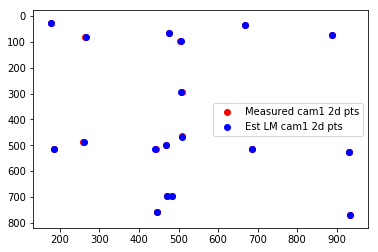

In [37]:
##########################     Extrisic matrix  #############################
fig,ax = plt.subplots()
fig.gca().invert_yaxis()
x1_est = Dehomogenize(K1 @ P1_LM @ Homogenize(X1))


ax.scatter(x1[0,:],x1[1,:], c = 'r',label = 'Measured cam1 2d pts')
ax.scatter( x1_est[0,:],x1_est[1,:], c = 'b',label = 'Est LM cam1 2d pts')
ax.legend()
#fig.savefig('Cam1_2d_pts.png')

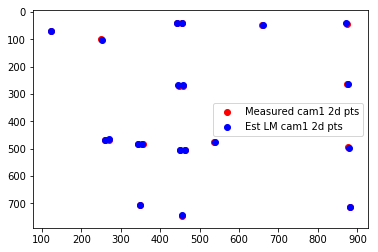

In [38]:
fig,ax = plt.subplots()
fig.gca().invert_yaxis()
 
x2_est = Dehomogenize(K2 @ P2_LM @ Homogenize(X2))


ax.scatter(x2[0,:],x2[1,:], c = 'r',label = 'Measured cam1 2d pts')
ax.scatter( x2_est[0,:],x2_est[1,:], c = 'b',label = 'Est LM cam1 2d pts')
ax.legend()
#fig.savefig('Cam2_2d_pts.png')

## 3D reconstruction -- Optimal Triangulation

In [39]:
index = []
for i in range (X1.shape[1]):
    for j in range (X2.shape[1]):
        if(( X1[:,i][0] ==  X2[:,j][0]) and ( X1[:,i][1] ==  X2[:,j][1]) and ( X1[:,i][2] ==  X2[:,j][2])):
            index.append([i,j])
    

In [40]:
index

[[4, 4], [9, 14], [11, 12], [13, 16], [17, 19]]

### Estimate Essential matrix 

In [41]:
def skew(w):
    # Returns the skew-symmetrix represenation of a vector
    w_skew = np.zeros((3,3))
    w_skew = np.array([[0,-w[2],w[1]],[w[2],0,-w[0]],[-w[1],w[0],0]])

    return w_skew

In [42]:
def Essential_E(P1_LM,P2_LM):
    #Compute essential matrix with two extrinsic matrix 
    R1 = P1_LM[:,0:3]
    T1 = P1_LM[:,-1].reshape(-1,1)
    R2 = P2_LM[:,0:3]
    T2 = P2_LM[:,-1].reshape(-1,1)
    R = R2 @ R1.T
    T = T2 - R2@ R1.T @ T1
    E = skew(T.reshape(-1)) @ R
    
    return E

In [43]:
E = Essential_E(P1_LM,P2_LM)

### Optimal triangulation methods
Correct corresponding point to the nearest points with minimal distance error which meet the epipolar constraint. Back project two corrected points to a 3D plane and a 3D line. The intersection between 3D line and 3D plane are the 3D reconstructed point.

In [44]:
def square_dist(a,b,c,d,f1,f2,t):
    s = t**2/(1+f1**2*t**2) + (c*t + d)**2/((a*t+b)**2 + f2**2*(c*t+d)**2)
    return s 

In [45]:
def close_pt_origin(l1):
    # input:
    #    l1 - 2d line 
    #   x : 2d homo pt lied on line l1 that is closest to origin 
    x = np.zeros((3,1))
    x[0] = -l1[0] * l1[2]
    x[1] = -l1[1] * l1[2]
    x[2] = l1[0]**2 + l1[1]**2 
    return x

In [46]:
def orthogonal_Line(l1,x1):
    #compute orthogonal line of l1 which pass through x1
    #l1: 2d homo line 3*1  (a,b,c)
    #x1: 2d homo pt 3*1   (x,y,w)
    l_perp = np.array([[-l1[1,0]*x1[2,0]],
                       [l1[0,0]*x1[2,0]],
                       [l1[1,0]*x1[0,0]-l1[0,0]*x1[1,0]]])
    return l_perp

In [47]:
def ray_plane_X(x1_homo,x2_homo,F,p1,p2):
    #Compute 3D pts in world frame with ray plane intersection method 
    #inputs:
    #   x1_homo/x2_homo - two 2d corresponding HOMO pts in image 1,2 respectively after epipolar line constrain 
    #   p1,p2 - projection matrix  3*4
    #outputs:
    #   X - 3d INHOMO !!!!  pts in world frame with two 2d corresponding pts 
    
    l_prm = F @ x1_homo    # (3*1)
    l_perp = orthogonal_Line(l_prm, x2_homo)  #3*1
    plane_p = p2.T @ l_perp     #4*1 
    u,d,v = np.linalg.svd(p1)
    cc = v[-1,:].reshape(-1,1)  #4*1    Camera center in world frame 
    X_back_proj = p1.T @ np.linalg.inv(p1 @ p1.T) @ x1_homo  #4*1 back proj to 3D
    l_3D = cc @ X_back_proj.T - X_back_proj @ cc.T    #4*4 TWO pts in 3d determine a 3d line
    X = l_3D @ plane_p
    X = Dehomogenize(X)
    
    return X

In [48]:
def Optimal_3D_estmate(x1,x2,E,K1,K2,P1_LM,P2_LM):
    # estimate 3D pt with two 2d inhomo corresponding pt 
    # input: x1,x2 inhomo 2d corresponding pts in img1 and img2 respectively 
    #        p1,p2 extrinsic matrix in img1 and img2 respectively   
    # output: X inhomo 3d pt
    
    x1 = Dehomogenize(np.linalg.inv(K1) @ Homogenize(x1))
    x2 = Dehomogenize(np.linalg.inv(K2) @ Homogenize(x2))    
    
    T1 = np.array([[1,0,-x1[0]],[0,1,-x1[1]],[0,0,1]])
    T2 = np.array([[1,0,-x2[0]],[0,1,-x2[1]],[0,0,1]])
    E_trsl = np.linalg.inv(T2).T @ E @ np.linalg.inv(T1)
    u,d,vh = np.linalg.svd(E_trsl)
    e1 = vh[-1,:]*np.sign(vh[-1,-1])
    e2 = u[:,-1]*np.sign(u[-1,-1])
    scale1 = 1/np.sqrt(e1[0]**2 + e1[1]**2)
    scale2 = 1/np.sqrt(e2[0]**2 + e2[1]**2)
    e1 = scale1 * e1
    e2 = scale2 * e2
    R1 = np.array([[e1[0],e1[1],0],[-e1[1],e1[0],0],[0,0,1]])
    R2 = np.array([[e2[0],e2[1],0],[-e2[1],e2[0],0],[0,0,1]])
    E_rot = R2 @ E_trsl @ R1.T
    f1 = e1[2]
    f2 = e2[2]
    a = E_rot[1,1]
    b = E_rot[1,2]
    c = E_rot[2,1]
    d = E_rot[2,2]
    Coeff6 = -a*c*f1**4*(a*d - b*c)
    Coeff5 = (a**2 + c**2*f2**2)**2 - a*d*f1**4*(a*d - b*c) - b*c*f1**4*(a*d - b*c)
    Coeff4 = 2*(a**2 + c**2*f2**2)*(2*c*d*f2**2 + 2*a*b) - 2*a*c*f1**2*(a*d - b*c) - b*d*f1**4*(a*d - b*c)
    Coeff3 = 2*(a**2 + c**2*f2**2)*(b**2 + d**2*f2**2) + (2*c*d*f2**2 + 2*a*b)**2 - 2*a*d*f1**2*(a*d - b*c) - 2*b*c*f1**2*(a*d - b*c)
    Coeff2 = 2*(b**2 + d**2*f2**2)*(2*c*d*f2**2 + 2*a*b) - a*c*(a*d - b*c) - 2*b*d*f1**2*(a*d - b*c)
    Coeff1 = (b**2 + d**2*f2**2)**2 - a*d*(a*d - b*c) - b*c*(a*d - b*c)
    Coeff0 = - b*d*(a*d - b*c)
    Coeff = [Coeff6,Coeff5,Coeff4,Coeff3,Coeff2,Coeff1,Coeff0]
    root = np.roots(Coeff)
    real_values = root[np.isreal(root)]
    cost = np.inf
    if real_values.size != 0:
        real_flt64 = real_values.real[abs(real_values.imag)<1e-5]   #real_flt64 
        for i in real_flt64:
            if cost > square_dist(a,b,c,d,f1,f2,i):
                cost = square_dist(a,b,c,d,f1,f2,i)
                #print('cost:   ',cost,'\n')
                t_min = i
            
        l1 = np.array([t_min*f1, 1 , -t_min])
        l2 = np.array([-f2*(c*t_min+d), a*t_min+b, c*t_min+d])
        x1_homo = np.linalg.inv(T1) @ R1.T @ close_pt_origin(l1)
        x2_homo = np.linalg.inv(T2) @ R2.T @ close_pt_origin(l2)
        #x1_new  = Dehomogenize(x1_homo).reshape(-1)
        #x2_new = Dehomogenize(x2_homo).reshape(-1)

        X = ray_plane_X(x1_homo,x2_homo,E, P1_LM,P2_LM).reshape(-1)
        
    else:
        print('Zero real roots')
        
    x1_new  = Dehomogenize(K1 @ x1_homo).reshape(-1)
    x2_new  = Dehomogenize(K2 @ x2_homo).reshape(-1)
        
    return X,x1_new,x2_new

#### check triangulation results

In [49]:
x1[:,index[3][0]],x2[:,index[3][1]]# ground truth

(array([931.310228, 525.29333 ]), array([876.885485, 495.421875]))

In [50]:
X1[:,index[1][0]] # ground truth

array([117.8,  62.2, 180. ])

In [51]:
#Optimal triangulation method  - test one point 
X_opt,x1_opt,x2_opt = Optimal_3D_estmate(x1[:,index[1][0]].reshape(-1,1),
                                         x2[:,index[1][1]].reshape(-1,1),
                                         E,K1,K2,P1_LM,P2_LM)

print('X_opt :    ', X_opt)
print('X_error:     ',((X_opt - X1[:,index[1][0]])**2).sum())
print('x1_error:     ',((x1_opt - x1[:,index[1][0]])**2).sum())
print('x2_error:     ',((x2_opt - x2[:,index[1][1]])**2).sum())

X_opt :     [117.62904081  62.38273532 178.99951702]
X_error:      1.0635854366201838
x1_error:      0.006868146127550554
x2_error:      0.009631879777322183


In [53]:
X_opt/X1[:,index[1][0]]

array([0.99854873, 1.00293787, 0.99444176])

### Construct 3d flight trojactory

In [54]:
'''
##### start from 4200 frames  200 - 1200

##### cam1--2004 
``` 
roi_x = 50  #
roi_y = 0  #
roi_wth = 830 
roi_hght = 800
```

##### cam2--2003  BKG issues before 1200 frames
```
roi_x = 50  #
roi_y = 520  #
roi_wth = 400
roi_hght = 280
```
##### cam2--2003  BKG issues after 2300 frames
```
roi_x = 550  #
roi_y =0  #
roi_wth = 400
roi_hght = 300
'''
cam1_dir = '../10_31/OC312003_S/CAM1_2004_csv/' 
cam2_dir = '../10_31/OC312003_S/CAM2_2003_csv/before1200/'

#cam22_dir = '../10_31/OC312003_S/CAM2_2003_csv/After2300/'
#cam1_dir = 'CAM1_2004_csv/'              
#cam2_dir = 'CAM2_2003_csv/before1200/'



#cam1_dir = 'Test_Case/cam1_'
#cam2_dir = 'Test_Case/cam2_'

#cam1_dir = 'fall_down_test_v11/cam1_'
#cam2_dir = 'fall_down_test_v11/cam2_'

#### Construct 3d ellipsoid 
#### Draw 2d ellipse (for visualization only)


In [55]:
#     v2 cam1 x570  y470       cam2    x 400  y450 
#     v1cam1 x700   y 400  cam2fall down   600-400
 #     v2 cam1 x570  y470       cam2    x 400  y450  
#     v3 cam1 x570  y450       cam2    x 400  y450 

In [56]:
E = np.load('../Calibration/Eseentail_M.npy')
K1 = np.load('../Calibration/Intrisinc_M.npy')
K2 = K1
P1_LM = np.load('../Calibration/Proj1_M.npy')
P2_LM = np.load('../Calibration/Proj2_M.npy')

In [57]:
x1 = pd.read_csv(cam1_dir + 'Body_center.csv',index_col = 0, header = 0)
angle1 = pd.read_csv(cam1_dir + 'Body_orientation.csv',index_col = 0, header = 0)
axis1 = pd.read_csv(cam1_dir + 'ellipses_axis.csv',index_col = 0, header = 0)
x1 = np.array(x1)
angle1 = np.array(angle1)
axis1 = np.array(axis1)
np.save(cam1_dir + 'cen_np.npy',x1)
np.save(cam1_dir + 'angle_np.npy',angle1)
np.save(cam1_dir + 'axis_np.npy',axis1)

In [58]:
x1 = (np.load(cam1_dir + 'cen_np.npy') + np.array([50,0]))[:1000,:] #+ np.array([490,520])#np.array([420,100])#0-0    #60-60    550 500
x2 = np.load(cam2_dir + 'cen_np.npy')+ np.array([50,520]) #+ np.array([450,530])#np.array([180,100])#0-0

angle1 = np.load(cam1_dir + 'angle_np.npy')#[:1000].reshape(-1)
angle2 = np.load(cam2_dir + 'angle_np.npy')
axis1 = np.load(cam1_dir + 'axis_np.npy')#[:1000,:]
axis2 = np.load(cam2_dir + 'axis_np.npy')


#x1 = np.load(cam1_dir + 'pos1500.npy')
#x2 = np.load(cam2_dir + 'pos1500.npy')
'''angle1 = np.load(cam1_dir + 'angle1500.npy')#[:1000].reshape(-1)
angle2 = np.load(cam2_dir + 'angle1500.npy')
axis1 = np.load(cam1_dir + 'axis1500.npy')#[:1000,:]
axis2 = np.load(cam2_dir + 'axis1500.npy')'''




'''x1 = np.load(cam1_dir + 'pos4100.npy') 
x2 = np.load(cam2_dir + 'pos4100.npy') 
angle1 = np.load(cam1_dir + 'angle4100.npy')#[:1000].reshape(-1)
angle2 = np.load(cam2_dir + 'angle4100.npy')
axis1 = np.load(cam1_dir + 'axis4100.npy')#[:1000,:]
axis2 = np.load(cam2_dir + 'axis4100.npy')'''

'''x1 = np.load(cam1_dir + 'posV1.npy') 
x2 = np.load(cam2_dir + 'posV1.npy') 
angle1 = np.load(cam1_dir + 'angleV1.npy')#[:1000].reshape(-1)
angle2 = np.load(cam2_dir + 'angleV1.npy')
axis1 = np.load(cam1_dir + 'axisV1.npy')#[:1000,:]
axis2 = np.load(cam2_dir + 'axisV1.npy')'''


'''x1 = np.load(cam1_dir + 'pos_new.npy') 
x2 = np.load(cam2_dir + 'pos_new.npy') 
angle1 = np.load(cam1_dir + 'angle.npy')#[:1000].reshape(-1)
angle2 = np.load(cam2_dir + 'angle.npy')
axis1 = np.load(cam1_dir + 'axis.npy')#[:1000,:]
axis2 = np.load(cam2_dir + 'axis.npy')'''

"x1 = np.load(cam1_dir + 'pos_new.npy') \nx2 = np.load(cam2_dir + 'pos_new.npy') \nangle1 = np.load(cam1_dir + 'angle.npy')#[:1000].reshape(-1)\nangle2 = np.load(cam2_dir + 'angle.npy')\naxis1 = np.load(cam1_dir + 'axis.npy')#[:1000,:]\naxis2 = np.load(cam2_dir + 'axis.npy')"

In [116]:
#v8 cam1 x490 y520 450/100      cam2  x450 y530 350/100 
#x1 = x1 + np.array([490,520])
#x2 = x2 + np.array([450,530])
#np.save(cam1_dir + 'pos_new.npy',x1)
#np.save(cam2_dir + 'pos_new.npy',x2)



In [117]:
axis1_0 = axis1[:,0]
axis1_1 = axis1[:,1]
axis2_0 = axis2[:,0]
axis2_1 = axis2[:,1]

In [413]:
axis1_1 = np.load(cam1_dir + 'axis_length_est.npy')
axis2_1 = np.load(cam2_dir + 'axis_length_est.npy')
axis2_1

array([121.87267431, 122.25326604, 121.60184342, ..., 108.15584276,
       106.27158058, 110.0330734 ])

In [118]:
from matplotlib import patches

In [59]:
X_1200 = np.zeros((3,x1.T.shape[1]))
x1_corrected_cen = np.zeros((2,x1.T.shape[1]))
x2_corrected_cen = np.zeros((2,x1.T.shape[1]))
for i in range (X_1200.shape[1]):
    X_1200[:,i],x1_corrected_cen[:,i],x2_corrected_cen[:,i] = Optimal_3D_estmate(x1.T[:,i].reshape(-1,1),
                                                                                 x2.T[:,i].reshape(-1,1),
                                                                                 E,K1,K2,P1_LM,P2_LM)
   

In [60]:

((x1_corrected_cen - x1.T)**2).sum()

((x2_corrected_cen - x2.T)**2).sum()

3156.3842141616983

In [61]:
X_1200.shape

(3, 1000)

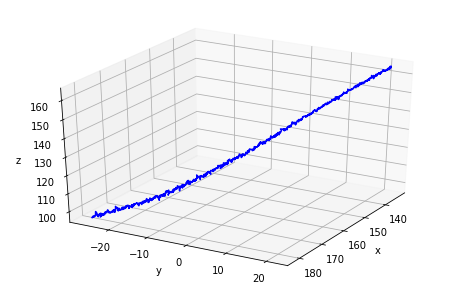

In [62]:
from mpl_toolkits.mplot3d import Axes3D
#ax,fig = plt.subplots()
#ax = plt.axes(projection='3d')
fig = plt.figure(figsize=(8,5))
ax=fig.add_subplot(111,projection='3d')
 
# Set rotation angle to 30 degrees

#ax.view_init(elev=30,azim= 10)
ax.view_init(30,30)
ax.plot(X_1200[0,:], X_1200[1,:],X_1200[2,:], '-b');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()
#fig.savefig(cam1_dir + '3D.png')
#fig.savefig( 'real3D.png')

#### Do not polyfit any ellipses' data
#### angle is in counter-clockwise rotation if Y-axis is upward. Vice versa 

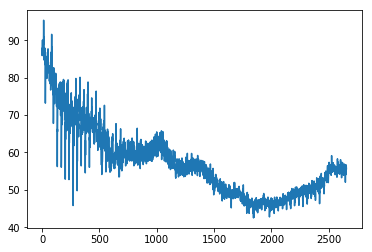

In [63]:
plt.plot(angle1)

In [64]:
angle1.shape

(2655, 1)

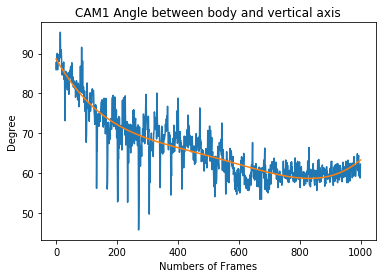

In [65]:
x_ori1 = np.linspace(0, x1.shape[0],x1.shape[0])
poly_ori1 = np.poly1d(np.polyfit(x_ori1,angle1[:1000,0],4)) 

body_ori1_1200 = poly_ori1(x_ori1)

fig,ax = plt.subplots()
ax.plot(angle1[:1000]);
ax.plot(body_ori1_1200);

ax.set_xlabel('Numbers of Frames')
ax.set_ylabel('Degree')
ax.set_title('CAM1 Angle between body and vertical axis');
#fig.savefig( 'angle1.png')


In [66]:
# angle 0 - 90
#Polyfit angle
#angle1 = body_ori1_1200.copy()

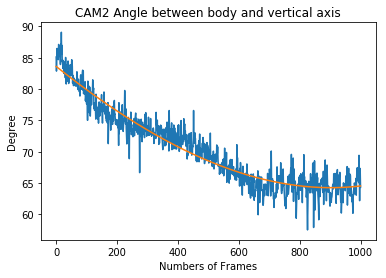

In [67]:
poly_ori2 = np.poly1d(np.polyfit(x_ori1,angle2,3)) 
body_ori2_1200 = poly_ori2(x_ori1)
fig,ax = plt.subplots()

ax.plot(angle2);
ax.plot(body_ori2_1200);

ax.set_xlabel('Numbers of Frames')
ax.set_ylabel('Degree')
ax.set_title('CAM2 Angle between body and vertical axis');
#fig.savefig( 'angle2.png')

In [1236]:
# angle 0 - 90
angle2 = body_ori2_1200.copy()

In [68]:
axis1.shape

(2655, 2)

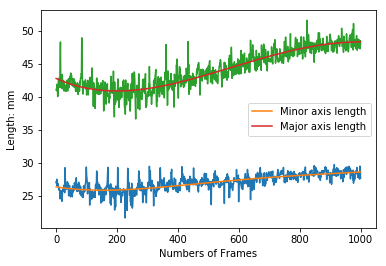

In [69]:
# axis1[1,:1000] major axis 
# axis1[0,:1000] minor axis 

fig,ax = plt.subplots()

poly_axis1_0 = np.poly1d(np.polyfit(x_ori1,axis1[:,0][:1000],4)) 
axis1_0 = poly_axis1_0(x_ori1)


poly_axis1_1 = np.poly1d(np.polyfit(x_ori1,axis1[:,1][:1000],4))
axis1_1 = poly_axis1_1(x_ori1)

ax.plot(axis1[:,0][:1000]);
ax.plot(axis1_0,label = 'Minor axis length')
ax.plot(axis1[:,1][:1000]);
ax.plot(axis1_1, label = 'Major axis length')
ax.set_xlabel('Numbers of Frames')
ax.set_ylabel('Length: mm')
ax.legend(loc = 'best')

#fig.savefig( 'LENGTH1.png')

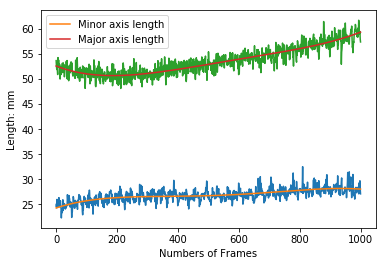

In [70]:
fig,ax = plt.subplots()

poly_axis2_0 = np.poly1d(np.polyfit(x_ori1,axis2[:,0],4)) 
axis2_0 = poly_axis2_0(x_ori1)


poly_axis2_1 = np.poly1d(np.polyfit(x_ori1,axis2[:,1],4))
axis2_1 = poly_axis2_1(x_ori1)

ax.plot(axis2[:,0]);
ax.plot(axis2_0,label = 'Minor axis length')
ax.plot(axis2[:,1]);
ax.plot(axis2_1,label = 'Major axis length')

ax.set_xlabel('Numbers of Frames')
ax.set_ylabel('Length: mm')
ax.legend(loc = 'best')

#fig.savefig( 'LENGTH2.png')

In [71]:
x_axis = 3.5 
y_axis = 8 
z_axis = 3.5 
###  Artifical bee test   
#x_axis  = 7
#y_axis  = 17.5  #17.5#16.5  #change from 17.5 to 15.5
#z_axis  = 5.84

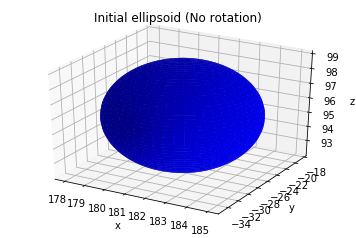

In [72]:
def ellipsoid(Cen, N_theta = 50, N_phi = 50, a = 3.5,b =8 ,c = 3.5):
    # get 3d ellipsoid surface pts 
    # inputs:
    #     N_theta, N_phi - number of pts needed 
    #     a,b,c - axis length for x, y , z axis respectively 
    #     Cen - ellipsoid 3D center

    # outputs: x,y,z surface pts 


    phi = np.linspace(0,2*np.pi, N_phi).reshape(-1) # the angle of the projection in the xy-plane
    theta = np.linspace(0, np.pi, N_theta).reshape(-1) # the angle from the polar axis, ie the polar angle

    # Transformation formula for a spherical coordinate system.
    x = np.zeros((theta.shape[0],phi.shape[0]))
    y = np.zeros((theta.shape[0],phi.shape[0]))
    z = np.zeros((theta.shape[0],1))


    for i in range (theta.shape[0]):
        for j in range (phi.shape[0]):
            x[i,j] = a * np.sin(theta[i])*np.cos(phi[j]) + Cen[0]
            y[i,j] = b * np.sin(theta[i])*np.sin(phi[j]) + Cen[1]
            z[i,0] = c * np.cos(theta[i]) + Cen[-1]

    temp_z = np.array([z[:,0]] * N_phi).T   
    X_ellipse = np.vstack((x.reshape(1,-1),y.reshape(1,-1),temp_z.reshape(1,-1)))
    
    
    
    return x,y,z,X_ellipse

index_check = 0

fig = plt.figure()  
ax = fig.add_subplot(111, projection='3d');
x,y,z,X_ellipse_test = ellipsoid(X_1200[:,index_check] )
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.plot_surface(x,y,z, color='b');
ax.set_title('Initial ellipsoid (No rotation)');
#fig.savefig('3D_Ellipsoid.png')

In [73]:
_,_,_,X_ellipse_test= ellipsoid(X_1200[:,0], N_theta = 100, N_phi = 100, a = x_axis,b = y_axis ,c = z_axis)

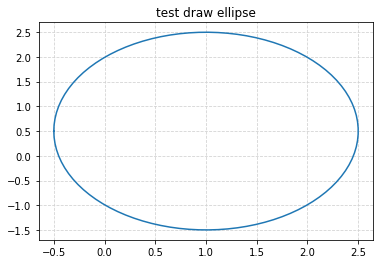

In [74]:
def ellipse_bondary_pts(xy,axis1_0, axis1_1,angle, N):
    # for drawing ellipse and get 2d ellipse boundary pts 
    # inputs:
    #     xy - ellipse center 
    #     a -  Corrsponding to x axis # half axis length --- axis1_0
    #     b  - Corrsponding to y axis  # half axis length --- axis1_1
    #     angle - ellipse orientation (in degree)
    #     N - numbers of boundary pts 
    # outputs:
    #     pt - 2d ellipse boundary pt 2*N
    a = axis1_0/2
    b = axis1_1/2
    
    angle = angle *pi / 180
    theta = np.linspace(0,2*pi, N)
    xx = a * np.sin(theta) 
    yy = b * np.cos(theta) 
    boundary_pt = np.vstack((xx,yy))
    R_rot = np.array([[cos(angle) , -sin(angle)],[sin(angle) , cos(angle)]]) 
    pt = R_rot @ boundary_pt + xy.reshape(-1,1)
    return pt 
test_pt =  ellipse_bondary_pts(np.array([1,0.5]),4,3,90, 100)
plt.grid(color='lightgray',linestyle='--');
plt.plot(test_pt[0,:],test_pt[1,:]);
plt.title('test draw ellipse');

#### Back proj ellipsoid to 2d image 

In [75]:
# 3d ellipsoid back proj to two cam frames respectively 
def ellipsoid2ellipse(X,K,P):
    #inputs:
    #    X:ellipsoid surface pts (3*N)
    #    P:Projection matrix 
    #outputs:
    #    x: 2d pts on image (2*N)
    x = Dehomogenize(K @ P @ Homogenize(X))
    
    return x


cam1_ellipse = ellipsoid2ellipse(X_ellipse_test,K1,P1_LM)
cam2_ellipse = ellipsoid2ellipse(X_ellipse_test,K2,P2_LM)

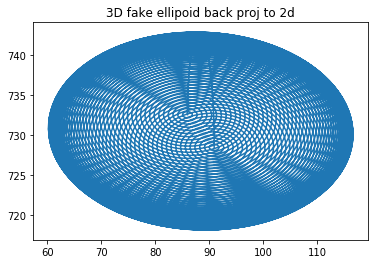

In [76]:
fig,ax = plt.subplots()
ax.plot(cam1_ellipse[0,:],cam1_ellipse[1,:]);
ax.set_title('3D fake ellipoid back proj to 2d');

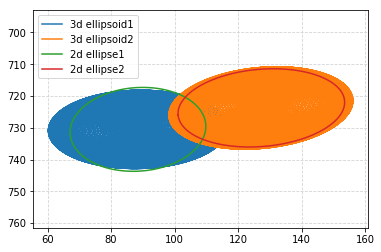

In [77]:
ellipse1_2d =  ellipse_bondary_pts(x1_corrected_cen[:,0],axis1_0[0],
                                   axis1_1[0],angle1[0], 100)
ellipse2_2d =  ellipse_bondary_pts(x2_corrected_cen[:,0],axis2_0[0],
                                   axis2_1[0],angle2[0], 100)

fig,ax = plt.subplots()
fig.gca().invert_yaxis()
ax.grid(color='lightgray',linestyle='--')
ax.axis('equal')
ax.plot(cam1_ellipse[0,:],cam1_ellipse[1,:],label = '3d ellipsoid1');
ax.plot(cam2_ellipse[0,:],cam2_ellipse[1,:],label = '3d ellipsoid2');
ax.plot(ellipse1_2d[0,:],ellipse1_2d[1,:], label = '2d ellipse1')
ax.plot(ellipse2_2d[0,:],ellipse2_2d[1,:], label = '2d ellipse2')
ax.legend(loc = 'best');
#fig.savefig('2d ellipses.png')

#### Find contour of ellipse (cam1_ellipse, cam2_ellipse)

In [78]:
def imgshow(img):
    cv2.imshow('Image',img)
    k=cv2.waitKey(0)
    if k==ord('s'):
        cv2.destroyAllWindows()

In [79]:
def pts2ellipse(pts):
    # Fit a 2d ellipse to 2d pts using OpenCV inside function cv2.fitEllipse
    # input:
    #     pts -- 2d pts got from 3d ellipsoid back proj to 2d image  2*N
    # outputs:
    #     ellipse -- format :  ((center_pos),(axis_a, axis_b, angle)
    #     axis_a -- x axis length  (whole length)
    #     axis_b -- y axis length   (whole length)
    #     angle -- rot angle from vertical axis(y-axis)
    #     center_pos is a litle offset from x1_corrected_cen. Thus Do not use the fist element in element array
    
    pts_int = pts.astype(int)
    pts_int = np.unique(pts_int,axis = 1) 
    img = np.zeros((800,1280), np.uint8) 
    for i in range (pts_int.shape[1]):
        img[pts_int[:,i][1],pts_int[:,i][0]] = 255
    _,contours,hierarchy_1 = cv2.findContours(img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 1:
        for kk in range(len(contours)):
            if (cv2.contourArea(contours[kk]) > 10):
                ellipse = cv2.fitEllipse(np.array(contours[kk]).reshape(-1,2))
    else:
        ellipse = cv2.fitEllipse(np.array(contours).reshape(-1,2))
    #ellipse = cv2.fitEllipse(np.array(contours).reshape(-1,2))
    axis_a = ellipse[1][0]
    axis_b = ellipse[1][1]
    angle = ellipse[2]
    return axis_a,axis_b, angle  
    

In [80]:
def ellipse_vertex(center, axis1_0, axis1_1, angle):
    #Convert from ellipse major, minor axis, angle to ellipse vertex
    # inputs:
    #     CENTER - (x,y)     image frame 
    #     axis_a - x axis (half_length) ---  minor 
    #     axis_b - y axis --- major 
    #     angle - in Degree  counter-clockwise !!!
    # outputs:
    #     x_pts1,2 - verteies along x axis in image FRAME before rotating
    #     y_pts1,2 - verteies along y axis in image FRAME before rotating
    
    axis_a =  axis1_0/2
    axis_b =  axis1_1/2
    
    
    center = center.reshape(-1,1)
    angle = angle*pi/180
    y_incre = np.array([axis_b * sin(angle), -axis_b * cos(angle)]).reshape(-1,1)
    x_incre = np.array([axis_a * cos(angle), axis_a * sin(angle)]).reshape(-1,1)
    x_pts1 = center + x_incre
    x_pts2 = center - x_incre
    y_pts1 = center + y_incre
    y_pts2 = center - y_incre
    #pts = np.array([[major_pts1],[major_pts2],[minor_pts1],[minor_pts2]])
    pts = np.hstack((x_pts1,x_pts2,y_pts1,y_pts2))
    return pts

In [81]:
pts2ellipse(cam1_ellipse)

(24.468114852905273, 56.85405349731445, 89.39445495605469)

In [82]:
ax1_a,ax1_b,angle1_3d = pts2ellipse(cam1_ellipse)
ax2_a,ax2_b,angle2_3d = pts2ellipse(cam2_ellipse)
test_fit1 = ellipse_vertex(x1_corrected_cen[:,0],ax1_a,ax1_b,angle1_3d)
test_fit2 = ellipse_vertex(x2_corrected_cen[:,0],ax2_a,ax2_b,angle2_3d)
test_1 = ellipse_vertex(x1_corrected_cen[:,0],axis1_0[0],
                        axis1_1[0],angle1[0])
test_2 = ellipse_vertex(x2_corrected_cen[:,0],axis2_0[0],
                        axis2_1[0],angle2[0])

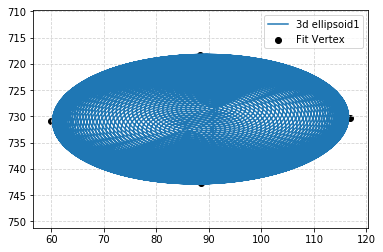

In [83]:
test_pts = ellipse_bondary_pts(x1_corrected_cen[:,0],ax1_a,ax1_b,angle1_3d,200 );
fig,ax = plt.subplots()
fig.gca().invert_yaxis()
ax.axis('equal')
ax.grid(color='lightgray',linestyle='--')
#ax.scatter(test_con[0,:],test_con[1,:],c = 'r',label = 'contour_pts ' )
ax.plot(cam1_ellipse[0,:],cam1_ellipse[1,:],label = '3d ellipsoid1');
#ax.plot(test_pts[0,:],test_pts[1,:],label = 'fit ellipse');
#ax.plot(ellipse1_2d[0,:],ellipse1_2d[1,:], label = '2d ellipse1')
#ax.plot(pts_int[0,:],pts_int[1,:],label = '3d ellipsoid int');
ax.scatter(test_fit1[0,:],test_fit1[1,:],c = 'k',label = 'Fit Vertex')
#ax.scatter(test_1[0,:],test_1[1,:],label = 'Ori Vertex')
ax.legend(loc = 'best');
#fig.savefig('Vertex')

#### Start to rotate the ellipsoid

In [84]:
#cam1_ellipse     # ellipsoid back proj to 2d image 
#cam2_ellipse 

In [85]:
#3d ellipse surface pts 
X_ellipse_test.shape

(3, 10000)

In [86]:
def rot(X_ellipse, X_cen, pitch_angle = 0, roll_angle = 0, yaw_angle = 0):
    # rotate 3D ellipsoid around its centroid
    # inputs:
    #     X_ellipse: surface pts with centroid X_cen
    #     X_cen: Ellipsoid center
    #     angle: all in degree
    # Outputs:
    #     X_rot: Surface pts after rotation 
    
    pitch_angle = pitch_angle*pi/180
    roll_angle = roll_angle*pi/180
    yaw_angle = yaw_angle*pi/180
    Rz = np.array([[cos(yaw_angle),-sin(yaw_angle),0],[sin(yaw_angle),cos(yaw_angle),0],[0,0,1]])
    Rx = np.array([[1,0,0],[0,cos(pitch_angle),-sin(pitch_angle)],[0,sin(pitch_angle),cos(pitch_angle)]])
    Ry = np.array([[cos(roll_angle),0,sin(roll_angle)],[0,1,0,],[-sin(roll_angle),0,cos(roll_angle)]])
    temp_X = X_ellipse - X_cen.reshape(-1,1)
    X_rot = (Rz @ Rx @ Ry @ temp_X) + X_cen.reshape(-1,1)
    

    return X_rot

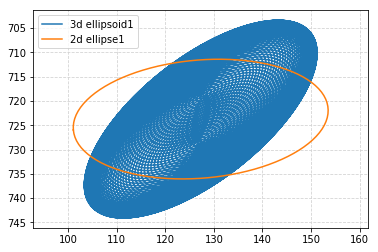

In [89]:
X_rot = rot(X_ellipse_test,X_1200[:,0],pitch_angle = 20, yaw_angle = 40 )
cam2_rot = ellipsoid2ellipse(X_rot,K2,P2_LM)
fig,ax = plt.subplots()
fig.gca().invert_yaxis()
ax.grid(color='lightgray',linestyle='--')
ax.axis('equal')
ax.plot(cam2_rot[0,:],cam2_rot[1,:],label = '3d ellipsoid1');
ax.plot(ellipse2_2d[0,:],ellipse2_2d[1,:], label = '2d ellipse1')
ax.legend(loc = 'best');


# Define error function 

In [90]:
#NEW ONE WITH PERC
def sum_distance(pts1_fit,pts2_fit,pts1,pts2):
    #Compute the distance between two sets of vertex 
    #Only analyze distance err
    #inputs:
    #   pts_fit1,2: vertex of fit ellipse (3d ellipsoid)  ([minor_vertex, minor_vertex,major_vertex,major_vertex])
    #   pts1,2: veterx of origin ellipse (bee body contour) from video  ([minor_vertex, minor_vertex,major_vertex,major_vertex])
    
    #output:
    #   angle_err: for adjusting yaw
    #   dis: sum of distance of corresponding vertex for adjusting pitch
    
    temp_a1 = pts1_fit[:,2] - pts1_fit[:,3]
    temp_b1 = pts1[:,2] - pts1[:,3]
    
    Major_fit1 = np.linalg.norm(temp_a1)
    Major1 = np.linalg.norm(temp_b1)
    temp_cos1 = np.dot(temp_b1 , temp_a1)/(Major_fit1 * Major1) 
    
    temp_a2 = pts2_fit[:,2] - pts2_fit[:,3]
    temp_b2 = pts2[:,2] - pts2[:,3]
    Major_fit2 = np.linalg.norm(temp_a2)
    Major2 = np.linalg.norm(temp_b2)  
    temp_cos2 = np.dot(temp_b2 , temp_a2)/(Major_fit2  *  Major2) 
    
    temperr1 = abs(np.arccos(temp_cos1)*180/pi)
    temperr2 = abs(np.arccos(temp_cos2)*180/pi)
    
    if temperr1 > 90 :
        temperr1 = 180 - temperr1
    if temperr2 > 90 :
        temperr2 = 180 - temperr2
    
    angle_err = temperr1 + temperr2
    
    
    '''print('angle1:      ',temperr1)
    print('angle2:      ',temperr2)'''
    #partial_error = angle_error/90
    
    
    error2 = (abs((Major_fit1 * temp_cos1 - Major1)) + abs((Major_fit2 * temp_cos2 - Major2)))/2
    
    angle_perc = angle_err/90
    
    Minor_fit1 = np.linalg.norm(pts1_fit[:,0] - pts1_fit[:,1])
    Minor_fit2 = np.linalg.norm(pts2_fit[:,0] - pts2_fit[:,1])
    
    
     
    error_perc = (abs(Major_fit1 * temp_cos1 - Major1)/(abs(Major1 - Minor_fit1 * temp_cos1)+ abs(Major1 - Major_fit1 * temp_cos1) )
                  +  abs(Major_fit2 * temp_cos2 - Major2)/(abs(Major2 - Minor_fit2 * temp_cos2)+ abs(Major2 - Major_fit2 * temp_cos2)))
    
    #temp1 = np.linalg.norm(pts1_fit - pts1, axis = 0)
    #temp2 = np.linalg.norm(pts2_fit - pts2, axis = 0)
    #error1 = (temp1[0:2] + temp2[0:2]).sum()    #y-axis - image 
    #error2 = (temp1[2:] + temp2[2:]).sum()    #x -axis - image 
    #dis = temp1.sum()/2 + temp2.sum()/2
    
    
    return angle_perc,error_perc
    #return angle_err,error_perc
    #return angle_err,error2#,temperr1,temperr2
    
    
    

#### Combine funcs and take a guess for initial condition 

In [91]:
def ellipsoid2vertex(X_ellipse,X_cen,K1,K2,P1,P2,x1_cen,x2_cen):
    #Convert 3D ellipse to vertex of 2d ellipse in two images 
    #X_ellipse could come from a rotated ellipsoid 
    x1 = ellipsoid2ellipse(X_ellipse,K1,P1)
    x2 = ellipsoid2ellipse(X_ellipse,K2,P2)
    
    x1_a,x1_b,angle1 = pts2ellipse(x1)
    x2_a,x2_b,angle2 = pts2ellipse(x2)
    
    pts1_fit = ellipse_vertex(x1_cen, x1_a, x1_b, angle1)
    pts2_fit = ellipse_vertex(x2_cen, x2_a, x2_b, angle2)
    
    return pts1_fit,pts2_fit

In [92]:
def init_est(X_cen,K1,K2,P1,P2,x1_cen,ax1_a,ax1_b,body_ori1,x2_cen,ax2_a,ax2_b,body_ori2,max_iters):
    # For initial pitch and yaw guess only
    #inputs: 
    #    X_ellipse - 3*N inhomo 3d ellisoid surface pts, not rotated yet  
    #    X_cen  -  3*1  3d ellipsoid centroid
    #    x1_cen/x2_cen  -  2*1  2d inhomo center of ellipse  (reference)
    #    ax1/2_a/b   - local ellipse x/y axis length (whole length)  (reference)
    #    body_ori1/2 - rotate angle  (reference)
    #    P1,2  - 3*4 projection matrix 
    #outputs:
    #    error - sum distance of two corresponding vertex 
    #   test_2 = ellipse_vertex(x2_corrected_cen[:,0],axis2_0[0]/2,axis2_1[0]/2,body_ori2_1200[0])
    
    
    _,_,_,X_ellipse = ellipsoid(X_cen, N_theta = 100, N_phi = 100, a = x_axis,b = y_axis,c = z_axis)
    pts1_fit,pts2_fit = ellipsoid2vertex(X_ellipse,X_cen,K1,K2,P1,P2,x1_cen,x2_cen)
    
    pts1 = ellipse_vertex(x1_cen, ax1_a, ax1_b, body_ori1)
    pts2 = ellipse_vertex(x2_cen, ax2_a, ax2_b, body_ori2)
    
    angle_err,error = sum_distance(pts1_fit,pts2_fit,pts1,pts2) #initial error 
    
    roll_angle = 0 
    init_pitch = 0
    init_yaw = 0          
    error_sum = np.inf    
    #test for yaw 
    yaw_angle = -10    #(from -90 to 0 degree, Adjust this parameters if needed)
    for j in range (max_iters):
        yaw_angle += 90/(max_iters) 
        #print('yaw:    ', yaw_angle)
        X_rot = rot(X_ellipse, X_cen, init_pitch , roll_angle , yaw_angle)
        pts1_fit,pts2_fit = ellipsoid2vertex(X_rot,X_cen,K1,K2,P1,P2,x1_cen,x2_cen)
        
        angle_new,error_dist  = sum_distance(pts1_fit,pts2_fit,pts1,pts2)
        #print('new_error:     ',new_error)
        if angle_new < angle_err:
            init_yaw = yaw_angle
            angle_err = angle_new
            error = error_dist
            error_sum = angle_err + error
   
            
            
    #test for pitch 
    pitch_angle = 0   #(from 0 to 90 degree, Adjust this parameters if needed)
    for i in range (max_iters):
        pitch_angle += 90/(max_iters)
        X_rot = rot(X_ellipse, X_cen, pitch_angle , roll_angle, yaw_angle = init_yaw)
        
        pts1_fit,pts2_fit = ellipsoid2vertex(X_rot,X_cen,K1,K2,P1,P2,x1_cen,x2_cen)
        
        angle_2,new_error = sum_distance(pts1_fit,pts2_fit,pts1,pts2)
        if (new_error + angle_2)< error_sum:
            init_pitch = pitch_angle
            error = new_error   
            angle_err = angle_2
            error_sum = new_error + angle_2
        '''if new_error < error:
            init_pitch = pitch_angle
            error = new_error   
            angle_err = angle_2'''
    init_pitch = np.int(init_pitch)
    init_yaw = np.int(init_yaw)
    
    
    return angle_err,error,init_pitch,init_yaw
    

In [93]:
def error_est(angle):  
    #compute angle error and distance error for ellipse fitting method 
    #inputs: 
    # X_1200[:,i],init_pts2,x1_corrected_cen[:,i],x2_corrected_cen[:,i]
    #    angle -  pitch and yaw angle 
    #    pts1,2  - vetexes of two bees' bodies ellipse from two cams 
    #    X  - ellipsoid surface pts 
    #    cen - 3d ellipsoid center comes from triangulation
    pts1 = init_pts1
    pts2 = init_pts2
    cen = X_1200[:,i]
    _,_,_,X_ell = ellipsoid(cen, N_theta = 100, N_phi = 100, a = x_axis,b = y_axis,c = z_axis )
    X_rot = rot(X_ell, cen, pitch_angle = angle[0] , roll_angle = 0, yaw_angle = angle[1])
    pts1_fit,pts2_fit = ellipsoid2vertex(X_rot,cen,K1,K2,P1_LM,P2_LM,x1_corrected_cen[:,i],x2_corrected_cen[:,i])
    
    angle_err,error2 = sum_distance(pts1_fit,pts2_fit,pts1,pts2)
    
    return error2 +angle_err
    
        
    

In [94]:
def angle_est(angle):  
    #compute angle error and distance error for ellipse fitting method 
    #inputs: 
    # X_1200[:,i],init_pts2,x1_corrected_cen[:,i],x2_corrected_cen[:,i]
    #    angle -  pitch and yaw angle 
    #    pts1,2  - vetexes of two bees' bodies ellipse from two cams 
    #    X  - ellipsoid surface pts 
    #    cen - 3d ellipsoid center comes from triangulation
    pts1 = init_pts1
    pts2 = init_pts2
    cen = X_1200[:,i]
    _,_,_,X_ell = ellipsoid(cen, N_theta = 100, N_phi = 100, a = x_axis,b = y_axis,c = z_axis )
    X_rot = rot(X_ell, cen, pitch_angle = angle[0] , roll_angle = 0, yaw_angle = angle[1])
    pts1_fit,pts2_fit = ellipsoid2vertex(X_rot,cen,K1,K2,P1_LM,P2_LM,x1_corrected_cen[:,i],x2_corrected_cen[:,i])
    
    angle_err,error2 = sum_distance(pts1_fit,pts2_fit,pts1,pts2)
    
    return error2 #+angle_err

### Optimization -- the Nelder-Mead method

In [95]:
#from scipy.optimize import least_squares
from scipy.optimize import minimize

In [96]:
def Optimization_angle(init_pitch,init_yaw,error_est):
    #pts1  = init_pts1
    #pts2 = init_pts2
    #func = error_est(angle,pts1= init_pts1,pts2= init_pts2,cen = X_cen )
    init_angle = [init_pitch,init_yaw]
    res_1 = minimize(error_est, init_angle, method='Nelder-Mead')
    #res_2 = minimize(angle_est, init_angle, method='Nelder-Mead')
    #res = [res_1.x[0],res_2.x[1]]
    return res_1.x,res_1.fun


### Ground_True

In [420]:
cam2_dir

'fall_down_test_v11/cam2_'

In [428]:
'''cam1_ctr1 = np.load(cam1_dir +'ctr1_1500.npy')
cam1_ctr2 = np.load(cam1_dir +'ctr2_1500.npy')
cam2_ctr1 = np.load(cam2_dir +'ctr1_1500.npy')
cam2_ctr2 = np.load(cam2_dir +'ctr2_1500.npy')'''

'''cam1_ctr1 = np.load(cam1_dir +'ctr1_4100.npy')
cam1_ctr2 = np.load(cam1_dir +'ctr2_4100.npy')
cam2_ctr1 = np.load(cam2_dir +'ctr1_4100.npy')
cam2_ctr2 = np.load(cam2_dir +'ctr2_4100.npy')'''

cam1_ctr1 = np.load(cam1_dir +'ctr1_1500_step5.npy')
cam1_ctr2 = np.load(cam1_dir +'ctr2_1500_step5.npy')
cam2_ctr1 = np.load(cam2_dir +'ctr1_1500_step5.npy')
cam2_ctr2 = np.load(cam2_dir +'ctr2_1500_step5.npy')


'''cam1_ctr1 = np.load(cam1_dir +'ctr1.npy')
cam1_ctr2 = np.load(cam1_dir +'ctr2.npy')
cam2_ctr1 = np.load(cam2_dir +'ctr1.npy')
cam2_ctr2 = np.load(cam2_dir +'ctr2.npy')'''


'''cam1_ctr1 = np.load(cam1_dir +'ctr1V1.npy')
cam1_ctr2 = np.load(cam1_dir +'ctr2V1.npy')
cam2_ctr1 = np.load(cam2_dir +'ctr1V1.npy')
cam2_ctr2 = np.load(cam2_dir +'ctr2V1.npy')'''

"cam1_ctr1 = np.load(cam1_dir +'ctr1V1.npy')\ncam1_ctr2 = np.load(cam1_dir +'ctr2V1.npy')\ncam2_ctr1 = np.load(cam2_dir +'ctr1V1.npy')\ncam2_ctr2 = np.load(cam2_dir +'ctr2V1.npy')"

In [429]:
X_ctr1 = np.zeros((3,cam1_ctr1.shape[1]))
cam1_ctr1_cor = np.zeros((2,cam1_ctr1.shape[1]))
cam2_ctr1_cor = np.zeros((2,cam1_ctr1.shape[1]))
for i in range (cam1_ctr1.shape[1]):
    X_ctr1[:,i],cam1_ctr1_cor[:,i],cam2_ctr1_cor[:,i] = Optimal_3D_estmate(cam1_ctr1[:,i].reshape(-1,1),
                                                                                 cam2_ctr1[:,i].reshape(-1,1),
                                                                                 E,K1,K2,P1_LM,P2_LM)
    

In [430]:
X_ctr2 = np.zeros((3,cam1_ctr1.shape[1]))
cam1_ctr2_cor = np.zeros((2,cam1_ctr1.shape[1]))
cam2_ctr2_cor = np.zeros((2,cam1_ctr1.shape[1]))
for i in range (cam1_ctr1.shape[1]):
    X_ctr2[:,i],cam1_ctr2_cor[:,i],cam2_ctr2_cor[:,i] = Optimal_3D_estmate(cam1_ctr2[:,i].reshape(-1,1),
                                                                                 cam2_ctr2[:,i].reshape(-1,1),
                                                                                  E,K1,K2,P1_LM,P2_LM)
cam1_ctr1.shape   

(2, 301)

In [431]:
((cam1_ctr2_cor- cam1_ctr2)**2).sum()
#((cam2_ctr2_cor- cam2_ctr2)**2).sum()

129.1891439552932

### Test for single frame 

In [355]:
pitch_ctrl[13],yaw_ctrl[13]

(33.075113663631704, 36.602809010047544)

In [118]:
#initial guessing
i = 100


tic = time.time()
temp_para1 = (x1_corrected_cen[:,i],axis1_0[i],axis1_1[i],angle1[i])
temp_para2 = (x2_corrected_cen[:,i],axis2_0[i],axis2_1[i],angle2[i])
_,_,_,X_ellipse = ellipsoid(X_1200[:,i], N_theta = 100, N_phi = 100, a = x_axis,b = y_axis,c = z_axis)
init_arccos, init_error, init_pitch, init_yaw = init_est(X_1200[:,i],K1,K2,P1_LM,P2_LM,
                                                          *temp_para1,*temp_para2,max_iters = 50)
toc = time.time() - tic
print('initial guess\n')
print('took %f seconds'%toc)
print('cost:     ',init_error  + init_arccos)
print('init_pitch:     ',init_pitch)
print('init_yaw:     ',init_yaw)

initial guess

took 2.618995 seconds
cost:      0.2159880976630324
init_pitch:      41
init_yaw:      18


In [119]:
init_pts1 = ellipse_vertex(*temp_para1)
init_pts2 = ellipse_vertex(*temp_para2)

In [120]:
#init_pitch = 30
#init_yaw = 30
tic = time.time()
res1,res2 = Optimization_angle(init_pitch,init_yaw,error_est)
toc = time.time() - tic
print('Optimazation:\n')
print('took %.3f seconds'%toc)
print('frame   ==   ', i)
print('pitch:       ',res1[0])
print('yaw:         ',res1[1])
print('cost:        ',res2)

Optimazation:

took 12.717 seconds
frame   ==    100
pitch:        39.077718353271464
yaw:          19.34470596313477
cost:         0.18976880198488422


In [121]:
#initial error

ellipse1_2d =  ellipse_bondary_pts(*temp_para1, 100)
ellipse2_2d =  ellipse_bondary_pts(*temp_para2, 100)

X_rot = rot(X_ellipse,X_1200[:,i],pitch_angle = 0,roll_angle = 0,yaw_angle = 0)  # 30/ 27

ini_pts1_fit,ini_pts2_fit = ellipsoid2vertex(X_rot,X_1200[:,i],K1,K2,P1_LM,P2_LM,x1_corrected_cen[:,i],x2_corrected_cen[:,i])
ini_pts1 = ellipse_vertex(*temp_para1)
ini_pts2 = ellipse_vertex(*temp_para2)
ini_arccos,ini_error = sum_distance(ini_pts1_fit,ini_pts2_fit,ini_pts1,ini_pts2)
print('initial distance error:   ',ini_error)
print('initial angle error:   ',ini_arccos)

initial distance error:    0.6319589008463531
initial angle error:    0.2924457126193562


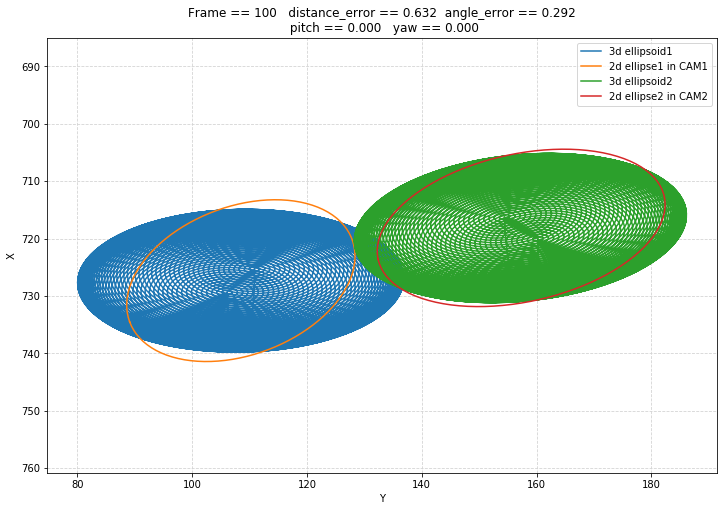

In [122]:
#visualization 

cam1_rot = ellipsoid2ellipse(X_rot,K1,P1_LM)
cam2_rot = ellipsoid2ellipse(X_rot,K2,P2_LM)
fig,ax1 = plt.subplots(figsize = (12,8))
fig.gca().invert_yaxis()
ax1.grid(color='lightgray',linestyle='--')
ax1.axis('equal')
ax1.plot(cam1_rot[0,:],cam1_rot[1,:],label = '3d ellipsoid1');
ax1.plot(ellipse1_2d[0,:],ellipse1_2d[1,:], label = '2d ellipse1 in CAM1')

ax1.plot(cam2_rot[0,:],cam2_rot[1,:],label = '3d ellipsoid2');
ax1.plot(ellipse2_2d[0,:],ellipse2_2d[1,:], label = '2d ellipse2 in CAM2')


#ax1.scatter(init_pts1[0,:],init_pts1[1,:],c = 'k',label = 'Fit Vertex')
#ax1.scatter(init_pts2[0,:],init_pts2[1,:],label = 'Ori Vertex')
ax1.set_xlabel('Y')
ax1.set_ylabel('X')
#ax1.set_title('Frame == %s   distance_error == %.3f  angle_error == %.3f\n pitch == %.3f   yaw == %.3f'
#             %(i,temp_error,temp_arccos,temp_pitch,temp_yaw))
ax1.legend(loc = 'best');
ax1.set_title('Frame == %s   distance_error == %.3f  angle_error == %.3f\n pitch == %.3f   yaw == %.3f'
             %(i,ini_error,ini_arccos,0,0));


#fig.savefig('Before adjusting orientation %s.png'%i)

In [123]:
# Optimization  

ellipse1_2d =  ellipse_bondary_pts(*temp_para1, 100)
ellipse2_2d =  ellipse_bondary_pts(*temp_para2, 100)

X_rot = rot(X_ellipse,X_1200[:,i],pitch_angle =res1[0],roll_angle = 0,yaw_angle = res1[1])  # 30/ 27
#X_rot = rot(X_ellipse,X_1200[:,i],pitch_angle =res1[0],roll_angle = 0,yaw_angle = res1[1])
ini_pts1_fit,ini_pts2_fit = ellipsoid2vertex(X_rot,X_1200[:,i],K1,K2,P1_LM,P2_LM,x1_corrected_cen[:,i],x2_corrected_cen[:,i])
ini_pts1 = ellipse_vertex(*temp_para1)
ini_pts2 = ellipse_vertex(*temp_para2)
ini_arccos,ini_error = sum_distance(ini_pts1_fit,ini_pts2_fit,ini_pts1,ini_pts2)
print('initial distance error:   ',ini_error)
print('initial angle error:   ',ini_arccos)

initial distance error:    0.10544263010988576
initial angle error:    0.08432617187499844


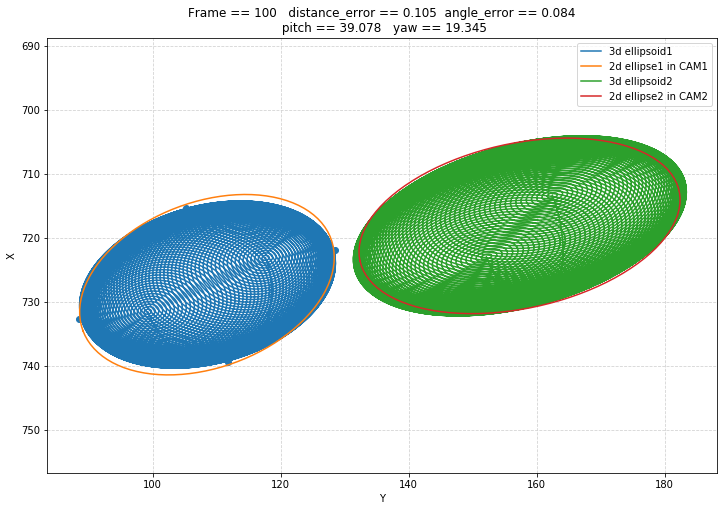

In [124]:
#visualization 
#ellipse1_2d =  ellipse_bondary_pts(*temp_para1, 100)
#ellipse2_2d =  ellipse_bondary_pts(*temp_para2, 100)

#X_rot = rot(X_ellipse,X_1200[:,i],pitch_angle =  res1[0],roll_angle = 0,yaw_angle =  res1[1])  # 30/ 27
cam1_rot = ellipsoid2ellipse(X_rot,K1,P1_LM)
cam2_rot = ellipsoid2ellipse(X_rot,K2,P2_LM)
fig,ax1 = plt.subplots(figsize = (12,8))
fig.gca().invert_yaxis()
ax1.grid(color='lightgray',linestyle='--')
ax1.axis('equal')
ax1.plot(cam1_rot[0,:],cam1_rot[1,:],label = '3d ellipsoid1');
ax1.plot(ellipse1_2d[0,:],ellipse1_2d[1,:], label = '2d ellipse1 in CAM1')
ax1.scatter(ini_pts1_fit[0,:],ini_pts1_fit[1,:])
ax1.plot(cam2_rot[0,:],cam2_rot[1,:],label = '3d ellipsoid2');
ax1.plot(ellipse2_2d[0,:],ellipse2_2d[1,:], label = '2d ellipse2 in CAM2')
ax1.set_xlabel('Y')
ax1.set_ylabel('X')
#ax1.set_title('Frame == %s   distance_error == %.3f  angle_error == %.3f\n pitch == %.3f   yaw == %.3f'
#             %(i,temp_error,temp_arccos,temp_pitch,temp_yaw))
ax1.legend(loc = 'best');
ax1.set_title('Frame == %s   distance_error == %.3f  angle_error == %.3f\n pitch == %.3f   yaw == %.3f'
             %(i,ini_error,ini_arccos,res1[0],res1[1]));


#fig.savefig('After adjusting orientation %s.png'%i)

#### Test for multiple frames

In [89]:
step = 10 #v11 1500
#step = 40  #v9
#step = 30  #v10
#step = 30  #v11  4100
#step = 20  #v8
if x1_corrected_cen.shape[1] % step == 0:
    N =  int(x1_corrected_cen.shape[1]/step)+1
else:
    N =  int(x1_corrected_cen.shape[1]/step)+2
#N =30
#N  = 30
N

101

In [90]:
error = np.zeros(N)
pitch = np.zeros(N)
yaw = np.zeros(N)
#angle_err = np.zeros(x1_corrected_cen.shape[1])
#error = np.zeros(x1_corrected_cen.shape[1])
#pitch = np.zeros(x1_corrected_cen.shape[1])
#yaw = np.zeros(x1_corrected_cen.shape[1])

#### Took initial guess at every begining of Optimaztion 

In [91]:
#Took initial guess at every begining of Optimaztion
tic = time.time()
#step = 5
for j in range (N): 
    i = j * step
    if i >= x1_corrected_cen.shape[1]:
        i = -1
    temp_para1 = (x1_corrected_cen[:,i],axis1_0[i],axis1_1[i],angle1[i])
    temp_para2 = (x2_corrected_cen[:,i],axis2_0[i],axis2_1[i],angle2[i])
    #_,_,_,X_ellipse = ellipsoid(X_1200[:,i])
    init_arccos, init_error, init_pitch, init_yaw = init_est(X_1200[:,i],K1,K2,P1_LM,P2_LM,
                                                              *temp_para1,*temp_para2,max_iters = 20)


    init_pts1 = ellipse_vertex(*temp_para1)
    init_pts2 = ellipse_vertex(*temp_para2)
    res1,error[j] = Optimization_angle(init_pitch,init_yaw,error_est)
    
    
    pitch[j],yaw[j] = res1 
    #pitch[i],yaw[i] = init_pitch, init_yaw
    print(i)
    
    
toc = time.time() - tic

print('took %f secs'%toc)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
-1
took 1221.155199 secs


### TEST MAJOR AXIS LENGTH WITH RECT!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Simulation

In [393]:
x1_corrected_cen.shape

(2, 687)

In [92]:
frame_N = [step * kk    for kk in range (N)]
frame_N[-1] = x1_corrected_cen.shape[1] 
 

In [93]:
len(frame_N)

101

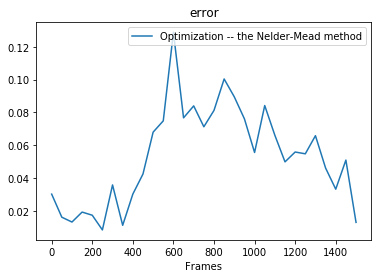

In [217]:
fig,ax = plt.subplots()

ax.plot(frame_N,error,label = 'Optimization -- the Nelder-Mead method')
ax.set_title('error');
#ax.set_ylabel('Angle degree')
ax.set_xlabel('Frames')
ax.legend(loc = 'best')
#fig.savefig(cam2_dir + 'errorV2.png')

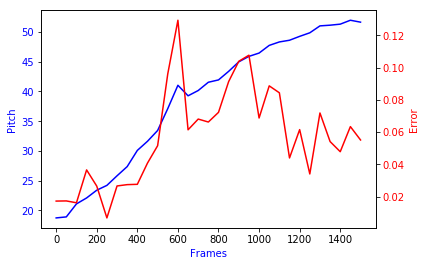

In [99]:
fig,ax1 = plt.subplots()
ax1.plot(frame_N,pitch, color = "blue")
ax1.set_ylabel(r"Pitch",color = "blue")
ax1.set_xlabel (r"Frames",color = "blue")
for label in ax1.get_yticklabels():
    label.set_color("blue")
ax2 = ax1.twinx()
ax2.plot(frame_N,error,color = "red")
ax2.set_ylabel(r"Error",color = "red")
for label in ax2.get_yticklabels():
    label.set_color("red")
#plt.savefig(cam2_dir+'Pitch_error.png')

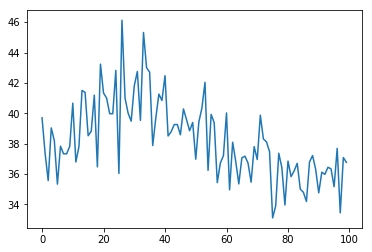

In [99]:
plt.plot(pitch[:-1])

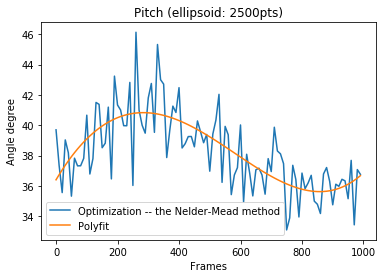

In [108]:
pitch_ori1 = np.linspace(0, frame_N[-2],len(frame_N)-1)
poly_pitch1 = np.poly1d(np.polyfit(pitch_ori1,pitch[:-1],4)) 
Pitch = poly_pitch1(pitch_ori1)

fig,ax = plt.subplots()
ax.plot(frame_N[:-1],pitch[:-1],label = 'Optimization -- the Nelder-Mead method')
ax.plot(frame_N[:-1],Pitch,label = 'Polyfit')
#ax.plot(pitch_old,label = 'Previous results')
ax.set_title('Pitch (ellipsoid: 2500pts)');
ax.set_ylabel('Angle degree')
ax.set_xlabel('Frames')
ax.legend(loc = 'best')
#fig.savefig(cam2_dir + 'PolyfitPITCH.png')
#fig.savefig('realPolyfitPITCH.png')

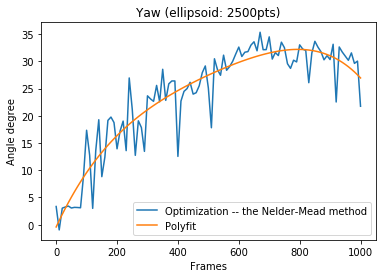

In [109]:
pitch_ori1 = np.linspace(0, frame_N[-1],len(frame_N))
poly_pitch1 = np.poly1d(np.polyfit(pitch_ori1,pitch,4)) 
poly_yaw1 = np.poly1d(np.polyfit(pitch_ori1,yaw,4))
Yaw = poly_yaw1(pitch_ori1)

fig,ax = plt.subplots()

ax.plot(frame_N,yaw,label = 'Optimization -- the Nelder-Mead method')
#ax.plot(yaw_old,label = 'Previous results')
ax.plot(frame_N,Yaw,label = 'Polyfit')
ax.set_title('Yaw (ellipsoid: 2500pts)');
ax.set_ylabel('Angle degree')
ax.set_xlabel('Frames')
ax.legend(loc = 'best')
#fig.savefig(cam2_dir + 'PolyfitYaw.png')
#fig.savefig( 'realPolyfitYaw.png')

In [223]:
yaw = Yaw
pitch = Pitch

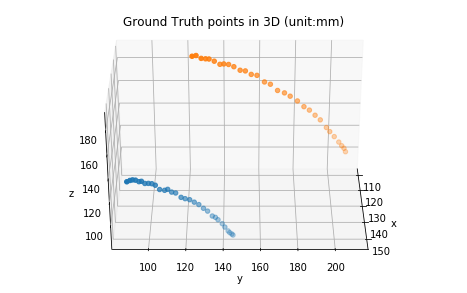

In [339]:
from mpl_toolkits.mplot3d import Axes3D
#ax,fig = plt.subplots()
#ax = plt.axes(projection='3d')
fig = plt.figure(figsize=(8,5))
ax=fig.add_subplot(111,projection='3d')
 
# Set rotation angle to 30 degrees

#ax.view_init(elev=30,azim= 10)
ax.view_init(30,0)
ax.scatter(X_ctr1[0,:], X_ctr1[1,:],X_ctr1[2,:], '-b');
ax.scatter(X_ctr2[0,:], X_ctr2[1,:],X_ctr2[2,:], '-b');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Ground Truth points in 3D (unit:mm)')
plt.show()
fig.savefig(cam2_dir + 'GT_3D.png')

In [135]:
#Save_dir = 'Running_results/'
Save_dir = '../Calibration/Running_results/'
#np.save(Save_dir + 'falldown_testv11_error_1500step_5.npy',error)
#np.save(Save_dir + 'OC1200_PITCH.npy',pitch)
#np.save(Save_dir + 'OC1200_yaw.npy',yaw)
'''np.save(Save_dir + 'falldown_testv11_error_1500_lengthest17.5.npy',error)
np.save(Save_dir + 'falldown_testv11_pitch_1500_lengthest17.5.npy',pitch)
np.save(Save_dir + 'falldown_testv11_yaw_1500_lenthest17.5.npy',yaw)'''
'''np.save(Save_dir + 'falldown_testv9_error_Length_est18.npy',error)
np.save(Save_dir + 'falldown_testv9_pitch_Length_est18.npy',pitch)
np.save(Save_dir + 'falldown_testv9_yaw_Length_est18.npy',yaw)'''

"np.save(Save_dir + 'falldown_testv9_error_Length_est18.npy',error)\nnp.save(Save_dir + 'falldown_testv9_pitch_Length_est18.npy',pitch)\nnp.save(Save_dir + 'falldown_testv9_yaw_Length_est18.npy',yaw)"

In [764]:
#pitch_old = np.load(Save_dir + 'falldown_test_poly_fit_pitchV8.npy')
#yaw_old = np.load(Save_dir + 'yawV1.npy')
#plt.plot(pitch_old)

### Load results

In [126]:
Save_dir = '../Calibration/Running_results/'

In [127]:
#pitch = np.load(Save_dir + 'falldown_testv11_pitch_1500.npy')
#yaw = np.load(Save_dir + 'falldown_testv11_yaw_1500.npy')

'''pitch = np.load(Save_dir + 'falldown_testv11_pitch_1500_lengthest17.5.npy')
yaw = np.load(Save_dir +   'falldown_testv11_yaw_1500_lenthest17.5.npy')'''

pitch = np.load(Save_dir + 'OC1200_PITCH.npy')
yaw = np.load(Save_dir + 'OC1200_YAW.npy')

'''pitch = np.load(Save_dir + 'falldown_testv11_pitch_1500step_100.npy')
yaw = np.load(Save_dir + 'falldown_testv11_yaw_1500step_100.npy')
'''
#pitch = np.load(Save_dir + 'falldown_testv8_pitch_perc_init_every_start.npy')
#yaw = np.load(Save_dir + 'falldown_testv8_yaw_perc_init_every_start.npy')

#pitch = np.load(Save_dir + 'falldown_testv10_pitch.npy')
#yaw = np.load(Save_dir + 'falldown_testv10_yaw.npy')

#pitch = np.load(Save_dir + 'falldown_testv9_pitch_Length_est.npy')
#yaw = np.load(Save_dir + 'falldown_testv9_yaw_Length_est.npy')

#pitch = np.load(Save_dir + 'falldown_testv11_pitch_4100.npy')
#yaw = np.load(Save_dir + 'falldown_testv11_yaw_4100.npy')

"pitch = np.load(Save_dir + 'falldown_testv11_pitch_1500step_100.npy')\nyaw = np.load(Save_dir + 'falldown_testv11_yaw_1500step_100.npy')\n"

In [200]:
pitch[0]

35.492102050781234

#### Results Analysis

In [396]:
X_ctr1.shape

(3, 36)

In [397]:
pitch.shape

(36,)

In [398]:
from sklearn.metrics import mean_squared_error
from math import sqrt



In [204]:
cam1_dir

'fall_down_test_v8/cam1_'

### Pitch yaw convertor (start with ground truth) 
Convert a 3D vector's orientation into pitch and yaw


In [266]:
#Test convertion 
test_norm1 = rot(np.array([[0],[1],[0]]), np.array([[0],[0],[0]]), pitch_angle =54, roll_angle = 0, yaw_angle = 67)
test_pitch = np.arcsin(test_norm1[-1,:])*180/np.pi  #pitch
test_yaw = -math.atan2(test_norm1[0,:], test_norm1[1,:])*180/np.pi #yaw
print('test pitch == %f \ntest yaw == %f'%(test_pitch,test_yaw))

test pitch == 54.000000 
test yaw == 67.000000


In [399]:
def Pitch_Yaw(X_ctr2 , X_ctr1):
    diff_ctr = X_ctr2 - X_ctr1
    norm_vector = diff_ctr/np.linalg.norm(diff_ctr,axis = 0)
    ctrl_yaw = np.zeros(norm_vector.shape[1])
    for ii in range (norm_vector.shape[1]):
        ctrl_yaw[ii] = -math.atan2(norm_vector[0,ii],norm_vector[1,ii])*180/np.pi #yaw
    ctrl_pitch = np.arcsin(norm_vector[-1,:])*180/np.pi  #pitch
    return ctrl_pitch, ctrl_yaw

In [400]:
#pitch_ctrl, yaw_ctrl = Pitch_Yaw(X_ctr1[:,:-1],X_ctr2[:,:-1])
pitch_ctrl, yaw_ctrl = Pitch_Yaw(X_ctr2,X_ctr1)

In [401]:
pitch_ctrl[0], yaw_ctrl[0]

(31.214197293372127, -4.212184385972979)

In [402]:
#pitch_ctrl = pitch_ctrl [:-1]   ##V8  
#yaw_ctrl = yaw_ctrl [:-1]    
#frame_N = frame_N[:-1]

In [403]:

rms_pitch = sqrt(mean_squared_error(pitch, pitch_ctrl))
rms_yaw = sqrt(mean_squared_error(yaw, yaw_ctrl))
print('rms_pitch == ', rms_pitch)
print('rms_yaw == ', rms_yaw)

rms_pitch ==  1.9829203175251613
rms_yaw ==  3.632003795599209


In [393]:
#np.save(cam1_dir +'PY'+ 'pitch_est_17.npy', pitch_est)
#np.save(cam1_dir +'PY'+ 'yaw_est_17.npy', yaw_est)
#np.save(cam1_dir + 'PY'+'pitch_GT.npy', pitch_test)
#np.save(cam1_dir + 'PY'+'yaw_GT.npy', yaw_test)


Text(0,0.5,'Number')

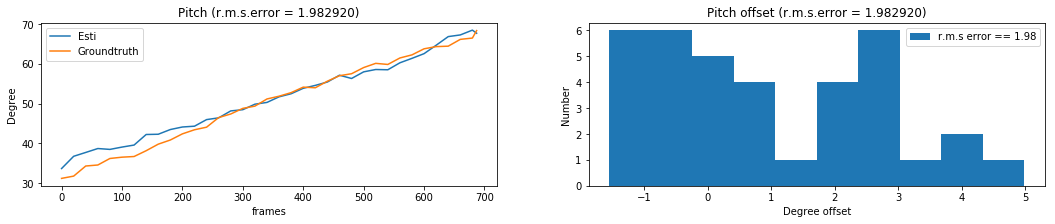

In [404]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (18,3))
ax1.plot(frame_N,pitch,label = 'Esti')
ax1.plot(frame_N,pitch_ctrl ,label = 'Groundtruth')
ax1.set_title('Pitch (r.m.s.error = %f)'%rms_pitch)
ax1.legend(loc = 'best')
ax1.set_xlabel('frames')
ax1.set_ylabel('Degree')

ax2.hist(pitch - np.array(pitch_ctrl) ,label = 'r.m.s error == %.2f'%rms_pitch)
ax2.set_title('Pitch offset (r.m.s.error = %f)'%rms_pitch);
ax2.legend(loc = 'best')
ax2.set_xlabel('Degree offset')
ax2.set_ylabel('Number')

#ax.set_title('Pitch')
#plt.savefig(cam1_dir + '17.5Compared_pitch.png')

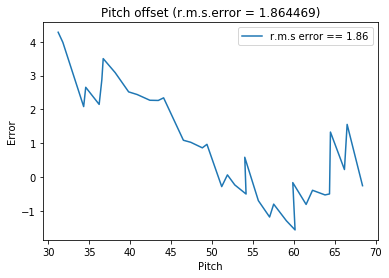

In [213]:
fig,ax = plt.subplots()
ax.plot(pitch_ctrl, pitch - np.array(pitch_ctrl) ,label = 'r.m.s error == %.2f'%rms_pitch)
ax.set_title('Pitch offset (r.m.s.error = %f)'%rms_pitch);
ax.legend(loc = 'best')
ax.set_xlabel('Pitch')
ax.set_ylabel('Error')
#plt.savefig(cam1_dir + '17.5Compared_pitch_offsetwith_pitch.png')

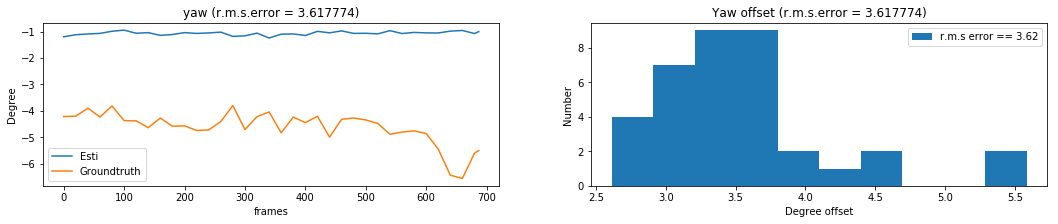

In [214]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (18,3))

ax1.plot(frame_N,yaw,label = 'Esti')
ax1.plot(frame_N,yaw_ctrl,label = 'Groundtruth')
ax1.set_title('yaw (r.m.s.error = %f)'%rms_yaw)
ax1.legend(loc = 'best')
ax1.set_xlabel('frames')
ax1.set_ylabel('Degree')
#ax.set_title('Yaw')


ax2.hist(yaw - np.array(yaw_ctrl) ,label = 'r.m.s error == %.2f'%rms_yaw)
ax2.set_title('Yaw offset (r.m.s.error = %f)'%rms_yaw);
ax2.legend(loc = 'best')
ax2.set_xlabel('Degree offset')
ax2.set_ylabel('Number')
#plt.savefig(cam1_dir + '17.5Compared_yaw.png')

In [ ]:
fig,ax = plt.subplots()
ax.plot(yaw_ctrl, yaw - np.array(yaw_ctrl) ,label = 'r.m.s error == %.2f'%rms_yaw)
ax.set_title('Yaw offset (r.m.s.error = %f)'%rms_yaw);
ax.legend(loc = 'best')
ax.set_xlabel('Yaw')
ax.set_ylabel('Error')
#plt.savefig(cam1_dir + '17.5Compared_yaw_offsetwith_yaw.png')

In [541]:
#YAW 
(3.61+2.470856+3.972+2.613428+1.517222)/5

3.0431534

In [407]:
#Refined Yaw
(3.61+2.164315+3.972+2.940129+1.517222)/5

2.8407332

In [405]:
#Refined Pitch
(1.864469+4.476051+2.35066+4.546590+4.690645)/5

3.5856830000000004

In [406]:
#Pitch
(1.854469+7.168420+2.35066+5.999322+4.690645)/5

4.4127032

In [ ]:
test_p1 = np.load(cam1_dir + 'PYpitch_est_17.5.npy')
test_y1 = np.load(cam1_dir + 'PYyaw_est_17.5.npy')
test_p2 = np.load(cam1_dir + 'PY'+'pitch_est_17.npy')
test_y2 = np.load(cam1_dir + 'PY'+'yaw_est_17.npy')
test_p3 = np.load(cam1_dir + 'PY'+'pitch_est_16.5.npy')
test_y3 = np.load(cam1_dir + 'PY'+'yaw_est_16.5.npy')
test_p4 = np.load(cam1_dir + 'PY'+'pitch_est_16.npy')
test_y4 = np.load(cam1_dir + 'PY'+'yaw_est_16.npy')
test_p5 = np.load(cam1_dir + 'PY'+'pitch_est_15.5.npy')
test_y5 = np.load(cam1_dir + 'PY'+'yaw_est_15.5.npy')
test_PGT = np.load(cam1_dir + 'pitch_GT.npy')
test_YGT = np.load(cam1_dir + 'yaw_GT.npy')

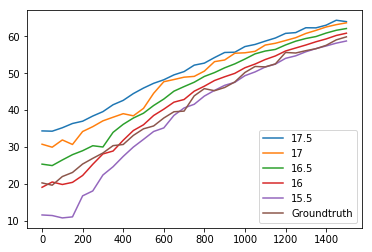

In [1713]:
fig,ax = plt.subplots()
ax.plot(frame_N, test_p1, label = '17.5')
ax.plot(frame_N,test_p2, label = '17')
ax.plot(frame_N,test_p3, label = '16.5')
ax.plot(frame_N,test_p4, label = '16')
ax.plot(frame_N,test_p5, label = '15.5')
ax.plot(frame_N,test_PGT ,label = 'Groundtruth')
ax.legend(loc = 'best')
#fig.savefig(cam1_dir + 'Bundlepitch.png')

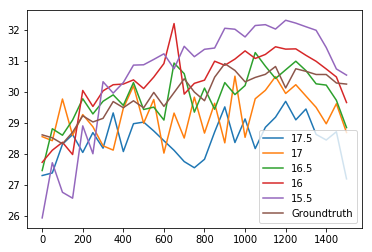

In [1714]:
fig,ax = plt.subplots()
ax.plot(frame_N, test_y1, label = '17.5')
ax.plot(frame_N,test_y2, label = '17')
ax.plot(frame_N,test_y3, label = '16.5')
ax.plot(frame_N,test_y4, label = '16')
ax.plot(frame_N,test_y5, label = '15.5')
ax.plot(frame_N,test_YGT ,label = 'Groundtruth')
ax.legend(loc = 'best')
#fig.savefig(cam1_dir + 'Bundleyaw.png')

#### Animation

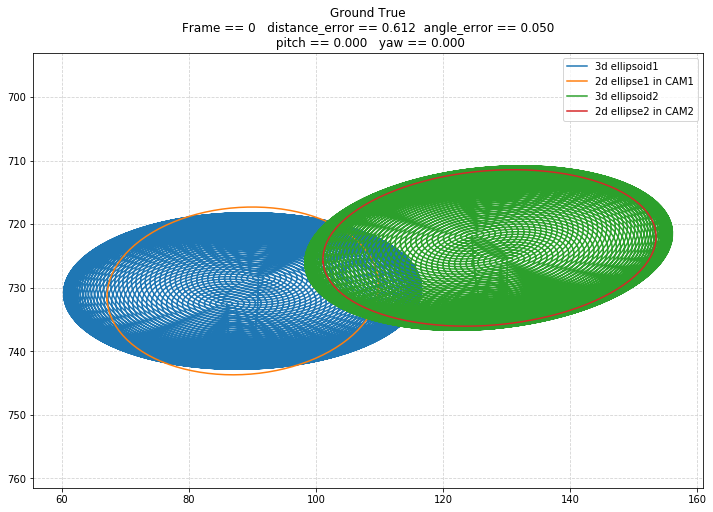

In [128]:
i = 0

temp_para1 = (x1_corrected_cen[:,i],axis1_0[i],axis1_1[i],angle1[i])
temp_para2 = (x2_corrected_cen[:,i],axis2_0[i],axis2_1[i],angle2[i])
_,_,_,X_ellipse = ellipsoid(X_1200[:,i], N_theta = 100, N_phi =100, a = x_axis, b = y_axis, c = z_axis)

ellipse1_2d =  ellipse_bondary_pts(*temp_para1, 100)
ellipse2_2d =  ellipse_bondary_pts(*temp_para2, 100)

X_rot = rot(X_ellipse,X_1200[:,i],pitch_angle = pitch[i],roll_angle = 0,yaw_angle = yaw[i] )  # 30/ 27

ini_pts1_fit,ini_pts2_fit = ellipsoid2vertex(X_rot,X_1200[:,i],K1,K2,P1_LM,P2_LM,x1_corrected_cen[:,i],x2_corrected_cen[:,i])
ini_pts1 = ellipse_vertex(*temp_para1)
ini_pts2 = ellipse_vertex(*temp_para2)
ini_arccos,ini_error = sum_distance(ini_pts1_fit,ini_pts2_fit,ini_pts1,ini_pts2)

cam1_rot = ellipsoid2ellipse(X_rot,K1,P1_LM)
cam2_rot = ellipsoid2ellipse(X_rot,K2,P2_LM)
fig,ax1 = plt.subplots(figsize = (12,8))
fig.gca().invert_yaxis()
ax1.grid(color='lightgray',linestyle='--')
ax1.axis('equal')
ax1.plot(cam1_rot[0,:],cam1_rot[1,:],label = '3d ellipsoid1');
ax1.plot(ellipse1_2d[0,:],ellipse1_2d[1,:], label = '2d ellipse1 in CAM1')

ax1.plot(cam2_rot[0,:],cam2_rot[1,:],label = '3d ellipsoid2');
ax1.plot(ellipse2_2d[0,:],ellipse2_2d[1,:], label = '2d ellipse2 in CAM2')

#ax1.set_title('Frame == %s   distance_error == %.3f  angle_error == %.3f\n pitch == %.3f   yaw == %.3f'
#             %(i,temp_error,temp_arccos,temp_pitch,temp_yaw))
ax1.legend(loc = 'best');
ax1.set_title('Ground True\nFrame == %s   distance_error == %.3f  angle_error == %.3f\n pitch == %.3f   yaw == %.3f'
             %(i,ini_error,ini_arccos,pitch[i],yaw[i]));




In [129]:
del fig,ax1

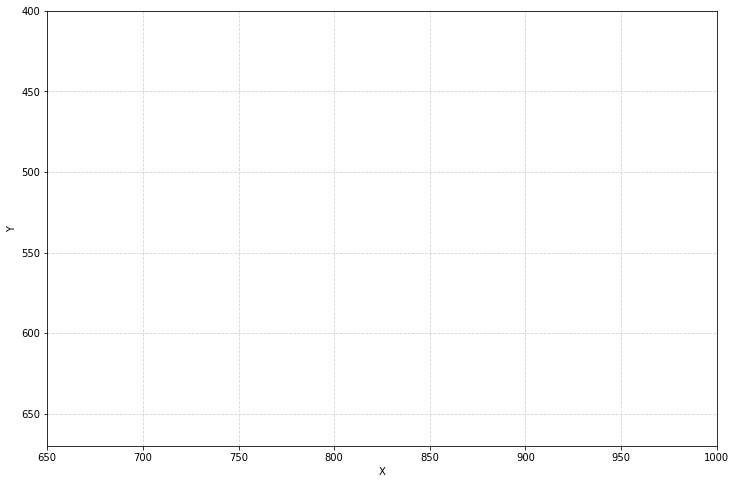

In [130]:
fig,ax1 = plt.subplots(figsize = (12,8))
ax1.grid(color='lightgray',linestyle='--')

ax1.set_xlim(( 650, 1000))   #v1
ax1.set_ylim((400, 670))
#ax1.set_xlim((50, 400))   #v2
#ax1.set_ylim((500, 800))

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
fig.gca().invert_yaxis()

In [131]:
#line, = ax.plot(x, x - 5, 'r-', linewidth=2)
line1, = ax1.plot([],[],label = '3d ellipsoid1');
line2, = ax1.plot([],[], label = '2d ellipse1 in CAM1')

line3, = ax1.plot([],[],label = '3d ellipsoid2');
line4, = ax1.plot([],[], label = '2d ellipse2 in CAM2')
ax1.legend(loc = 'best');

In [166]:
# check for ground truth 

#step = 30

#
def update(j):
    i = step * j
    if i >= x1_corrected_cen.shape[1]:
        i = -1
    temp_para1 = (x1_corrected_cen[:,i],axis1_0[i],axis1_1[i],angle1[i])
    temp_para2 = (x2_corrected_cen[:,i],axis2_0[i],axis2_1[i],angle2[i])
    _,_,_,X_ellipse = ellipsoid(X_1200[:,i], N_theta = 100, N_phi =100, a = x_axis, b = y_axis, c = z_axis)

    ellipse1_2d =  ellipse_bondary_pts(*temp_para1, 100)
    ellipse2_2d =  ellipse_bondary_pts(*temp_para2, 100)

    X_rot = rot(X_ellipse,X_1200[:,i],pitch_angle = pitch[j],roll_angle = 0,yaw_angle = yaw[j])  # 30/ 27

    ini_pts1_fit,ini_pts2_fit = ellipsoid2vertex(X_rot,X_1200[:,i],K1,K2,P1_LM,P2_LM,x1_corrected_cen[:,i],x2_corrected_cen[:,i])
    ini_pts1 = ellipse_vertex(*temp_para1)
    ini_pts2 = ellipse_vertex(*temp_para2)
    ini_arccos,ini_error = sum_distance(ini_pts1_fit,ini_pts2_fit,ini_pts1,ini_pts2)

    cam1_rot = ellipsoid2ellipse(X_rot,K1,P1_LM)
    cam2_rot = ellipsoid2ellipse(X_rot,K2,P2_LM)
    ax1.set_title('Frame == %s   distance_error == %.3f  angle_error == %.3f\n pitch == %.3f   yaw == %.3f'
             %(i,ini_error,ini_arccos,pitch[j],yaw[j]));
    line1.set_data(cam1_rot[0,:],cam1_rot[1,:])
    line2.set_data(ellipse1_2d[0,:],ellipse1_2d[1,:])
    line3.set_data(cam2_rot[0,:],cam2_rot[1,:])
    line4.set_data(ellipse2_2d[0,:],ellipse2_2d[1,:])
    
    #ax1.legend(loc = 'best');
    
    return line1,line2,line3,line4,ax1



In [167]:
from matplotlib import animation, rc
from IPython.display import HTML, Image
from matplotlib.animation import FuncAnimation

In [168]:
rc('animation', html='html5')

In [169]:
#anim = FuncAnimation(fig, update, frames=np.arange(0, x1_corrected_cen.shape[1]), interval=20)
anim = FuncAnimation(fig, update, frames=np.arange(0, N), interval=200)

In [170]:
anim

In [870]:
anim.save('Perc_animation_init_start.gif', writer='imagemagick', fps=200)

MovieWriter imagemagick unavailable.


In [722]:
anim.save('Perc_animation.avi', fps=200,bitrate = 36000)